## Imports

In [5]:
import bertFuncs as func
from functions import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from transformers import logging
logging.set_verbosity_error()
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
from nltk.corpus import wordnet as wn

from scipy.stats import ttest_ind
import math

In [6]:
# Set path for stored embeddings. 

path = "./averaged_embeddings (Full List)/"

## 1. Get Embeddings

### 1.1 Get Firm Embeddings

In [7]:
# Read S&P500 company names.
# Source: https://github.com/datasets/s-and-p-500-companies/blob/master/data/constituents.csv
#company_names = pd.read_csv("sp500.csv")

company_names = pd.read_csv("sp500companynames.csv")
company_names.rename(columns = {"cleanedname":"Name"}, inplace = True)

company_names["Count"] = company_names['Name'].str.split().apply(len)

In [ ]:
# Get embeddings for S&P 500 names. Average embeddings are calculated for multi-word firms. 

get_average_embedding(company_names["Name"], "worked")

### 1.1 Get Random Noun Embeddings

In [8]:
# Load and clean list of english nouns and generate random sample.

nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 800, random_state = 42)
nouns_sample = list(nouns_sample)

# Make sure no overlap between nouns and companies 
company_names["Name_Lower"] = company_names['Name'].str.lower()
nouns_sample = [x for x in nouns_sample if x not in list(company_names["Name_Lower"])]

In [280]:
"""

# Get embeddings for random nouns. 

get_average_embedding(nouns_sample, "works")

  0%|          | 0/500 [00:00<?, ?it/s]

## 2. Initial analysis

In [9]:
# Get all considered dimensions. 

dimensions = get_firm_embeddings("amazon", "works", 111, "all")
all_dimensions = dimensions["tuple"].unique()

### 2.1 Create Distribution Plots

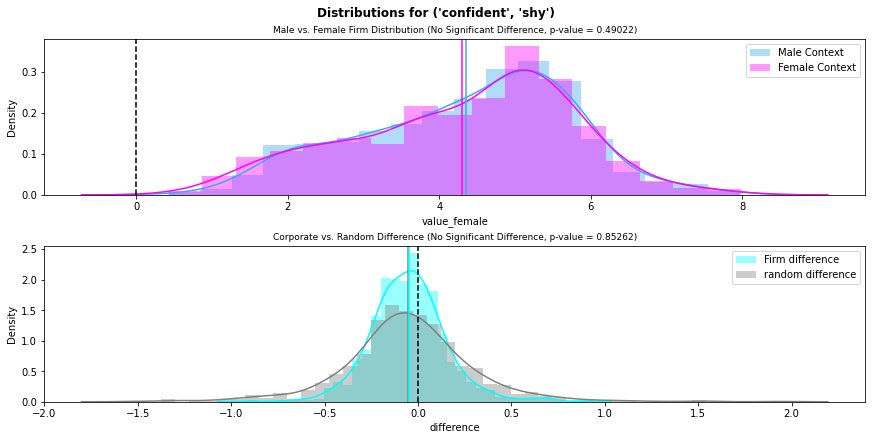

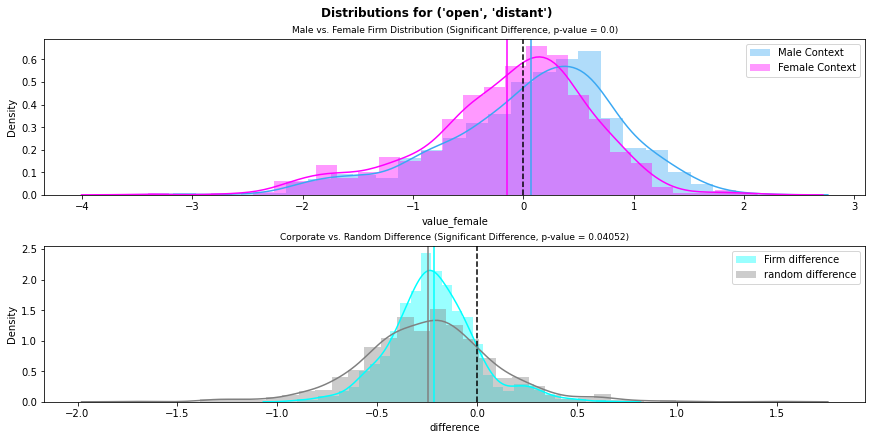

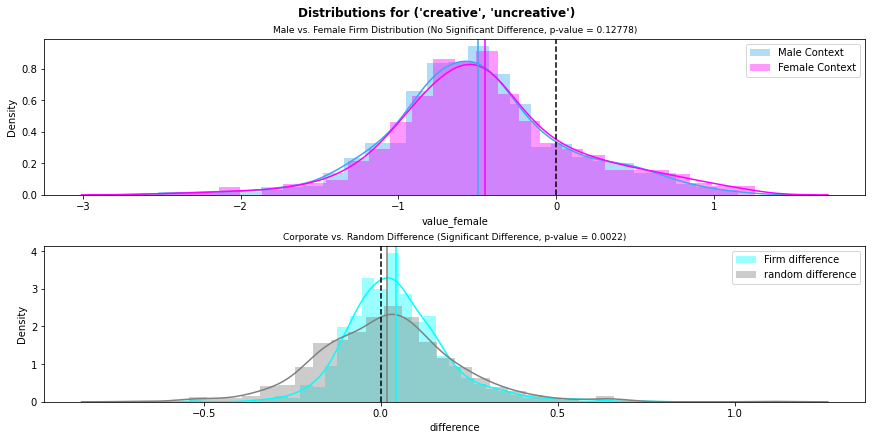

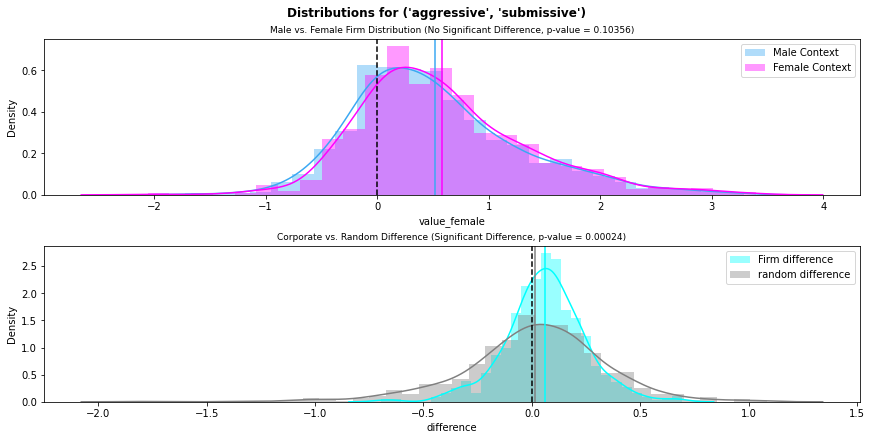

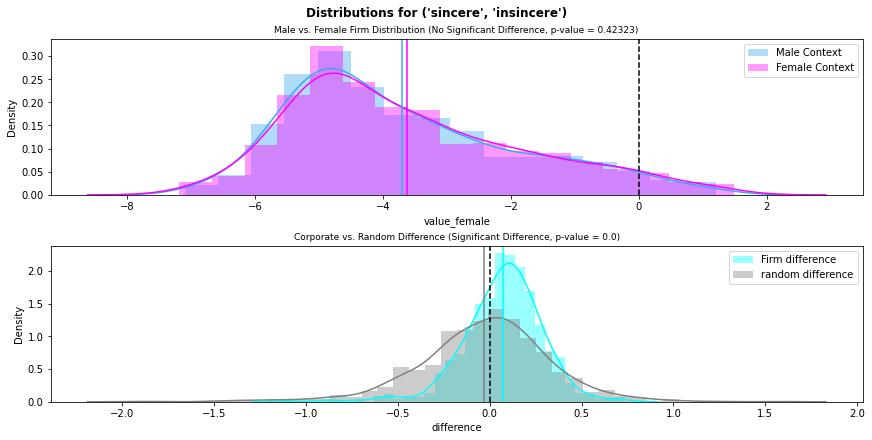

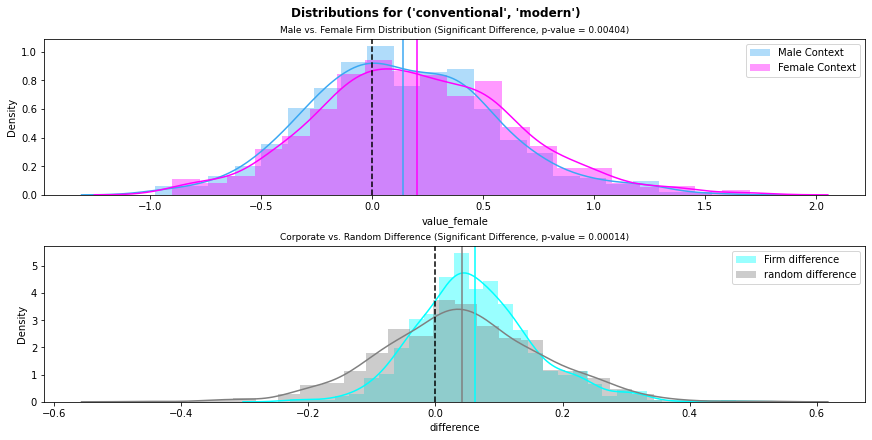

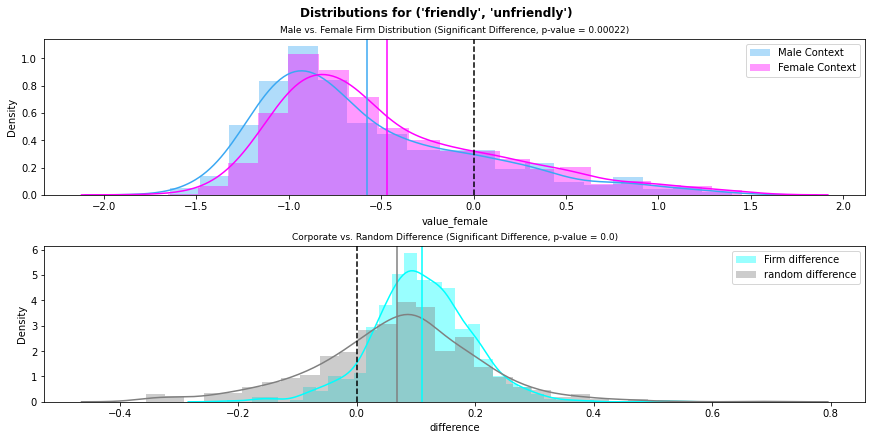

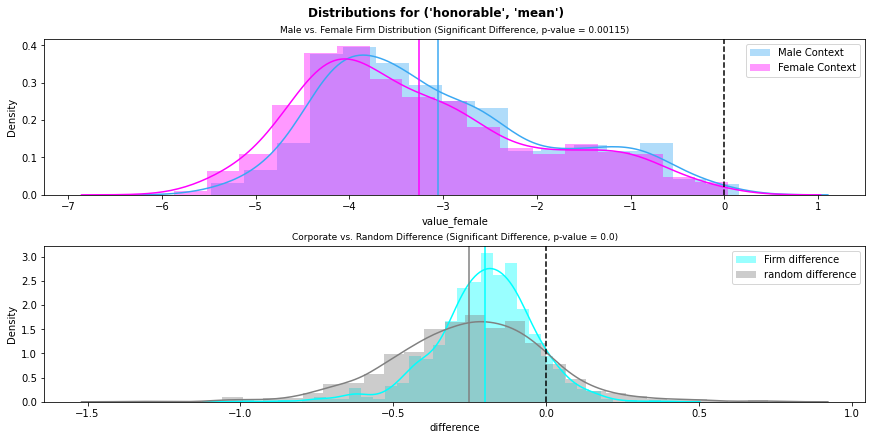

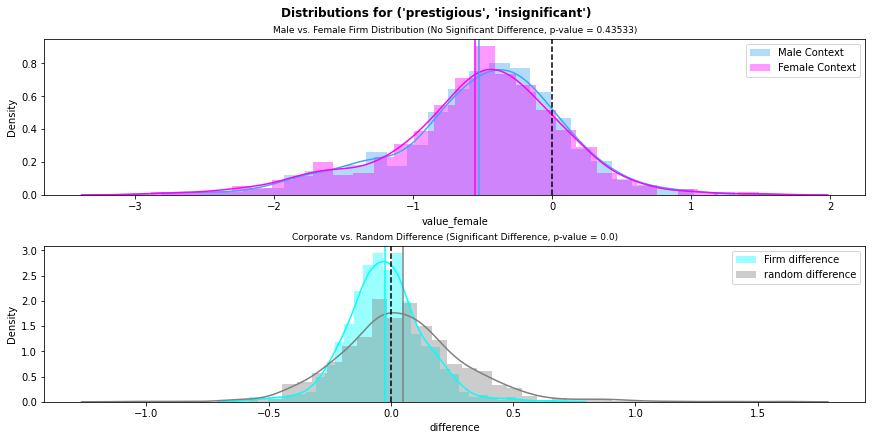

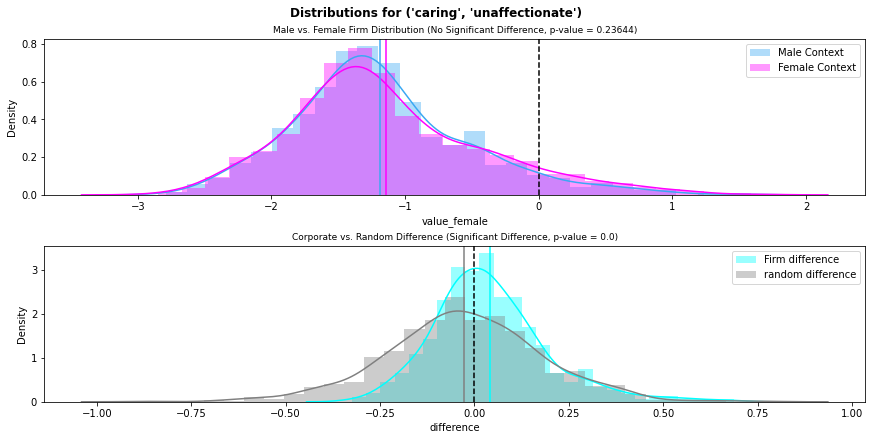

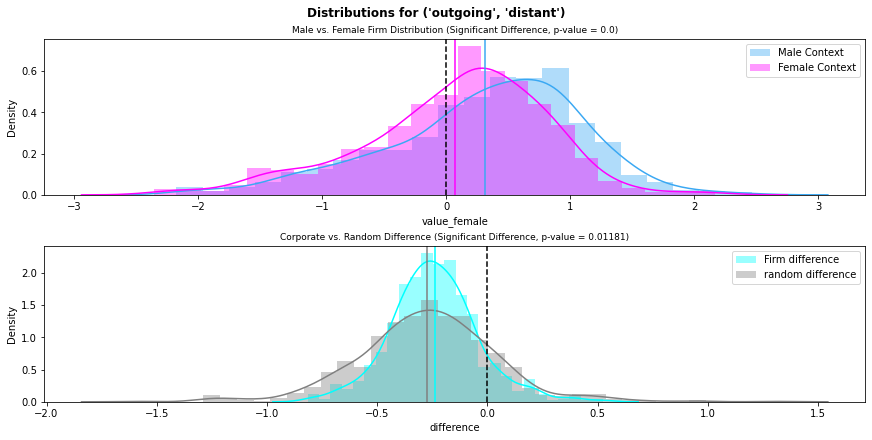

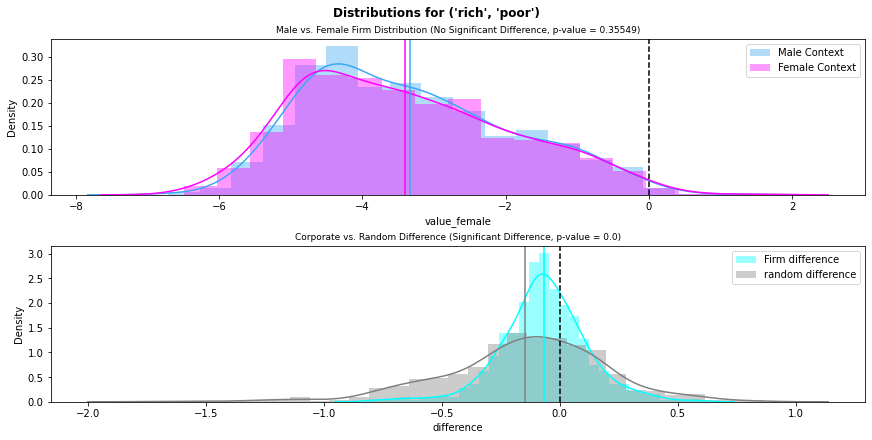

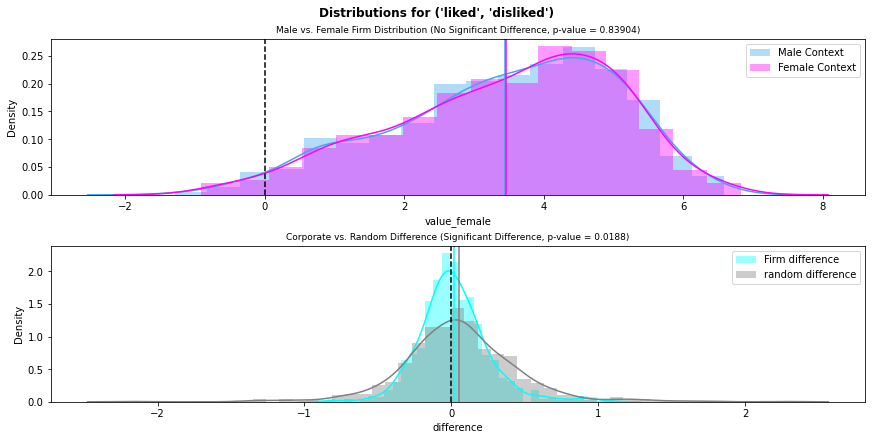

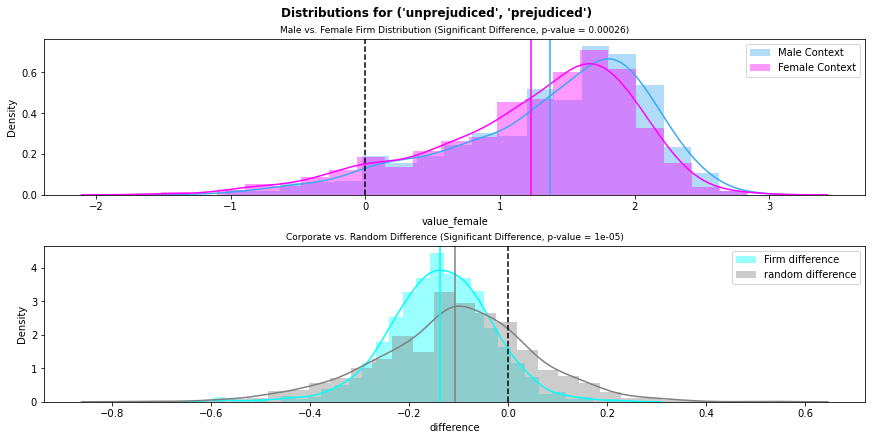

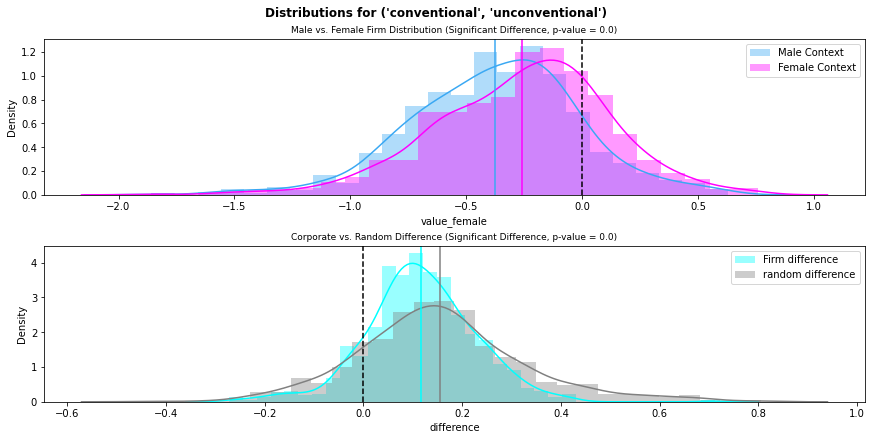

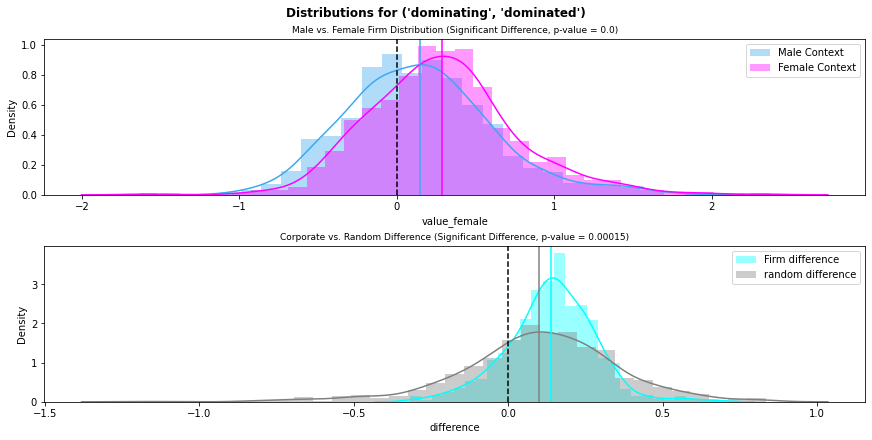

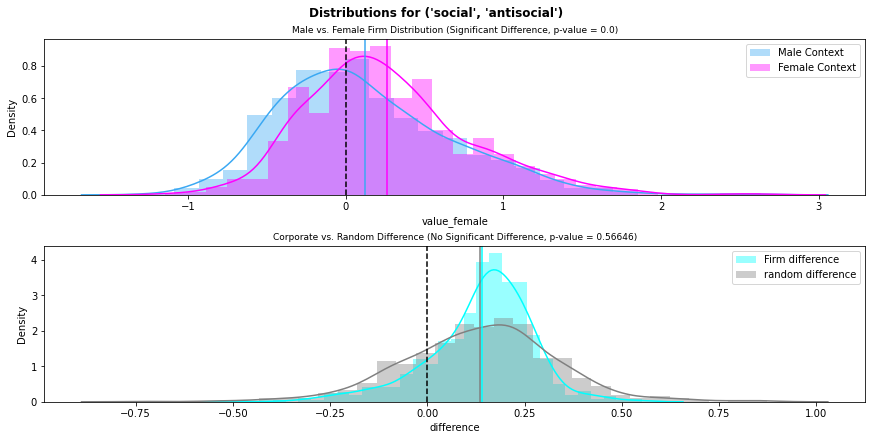

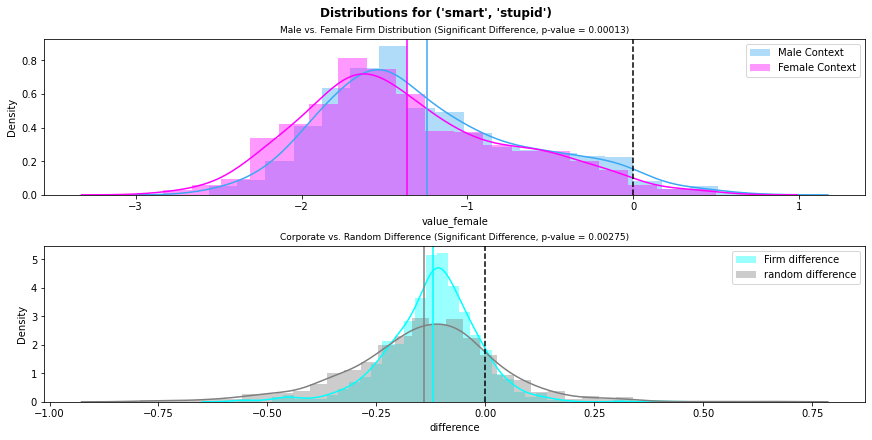

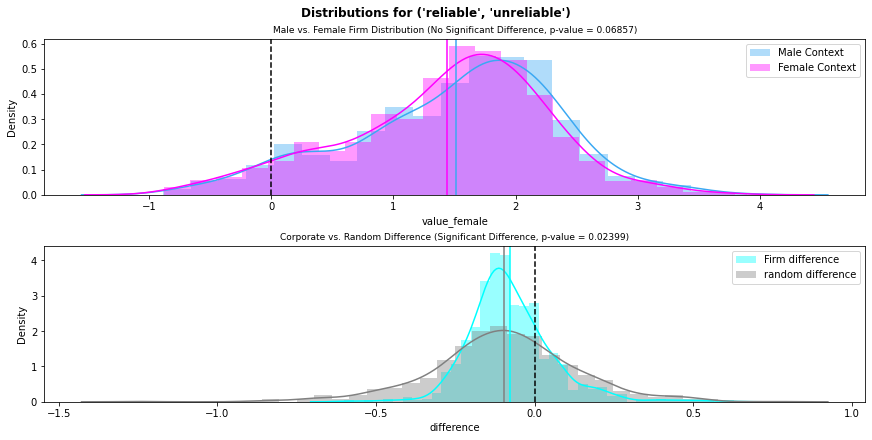

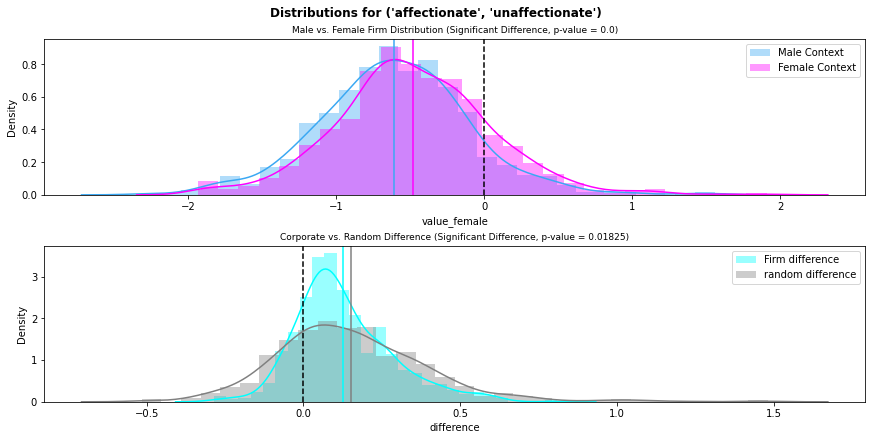

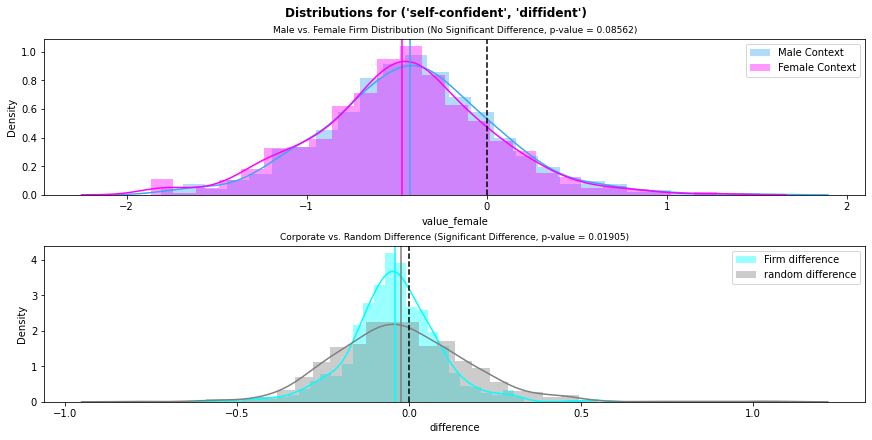

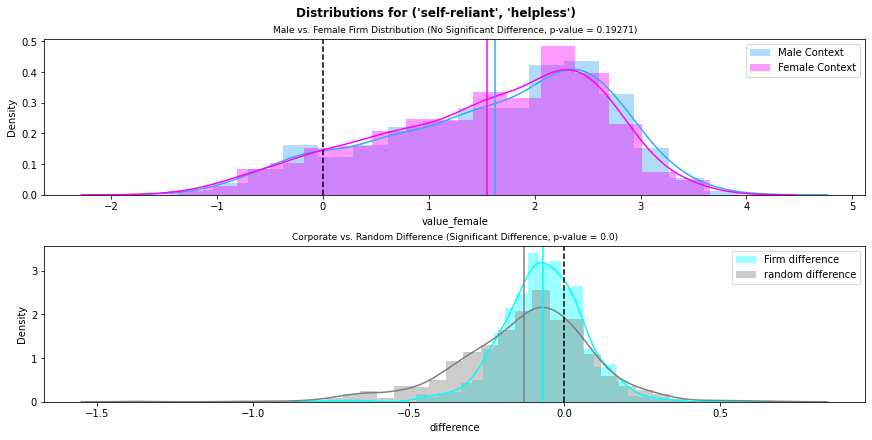

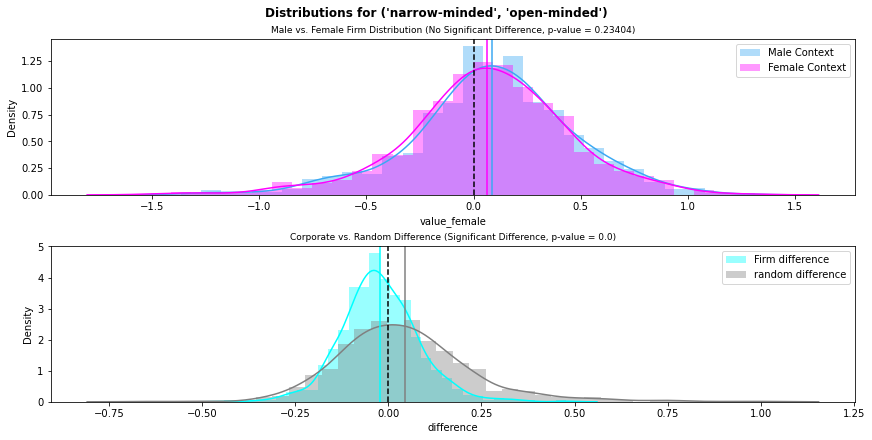

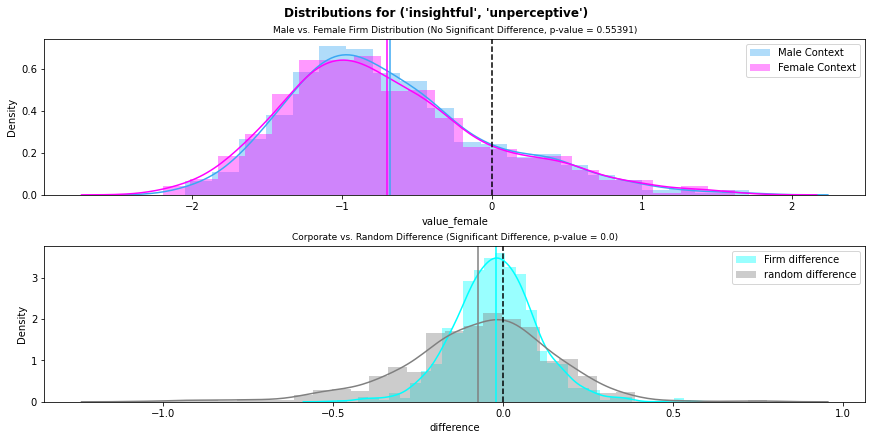

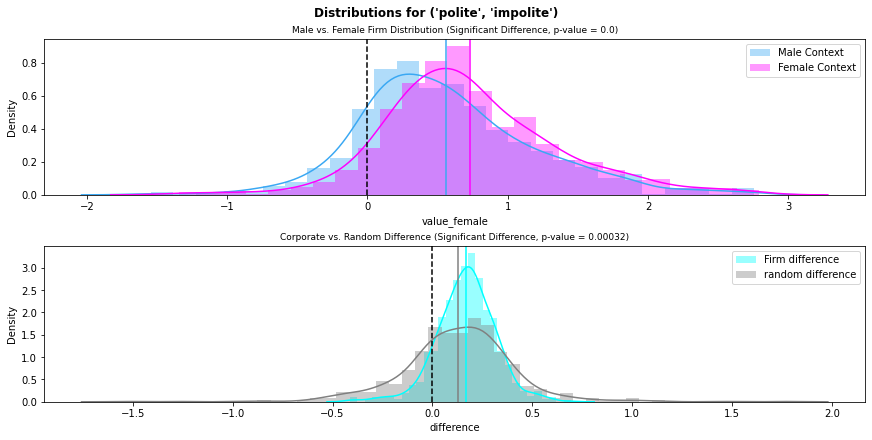

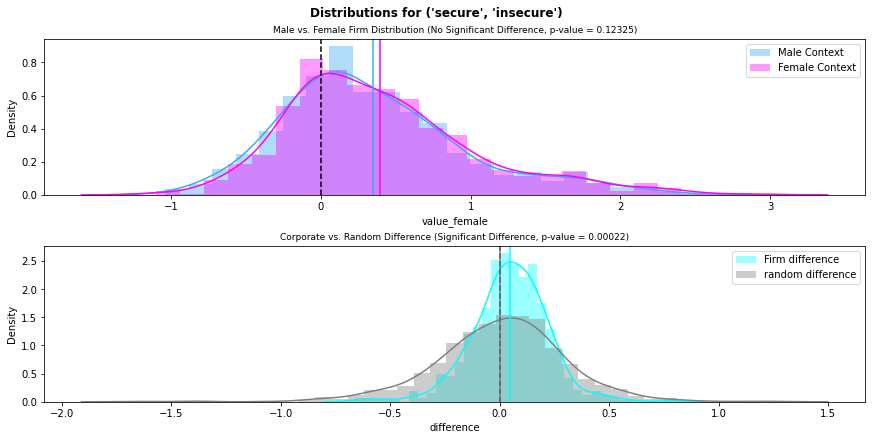

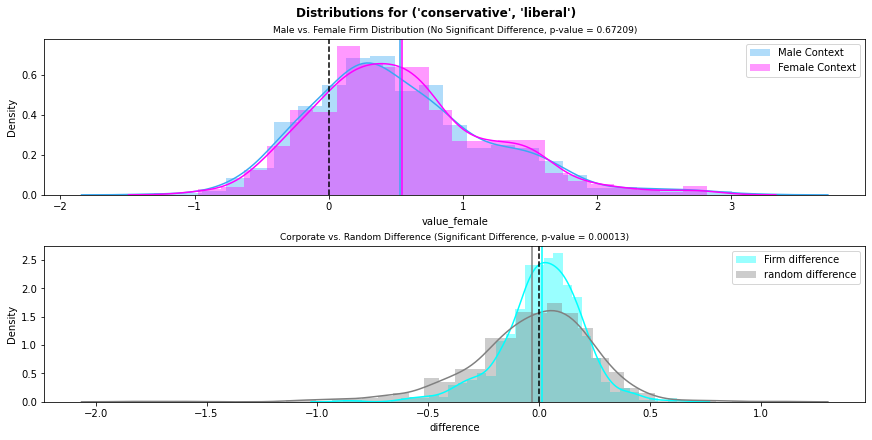

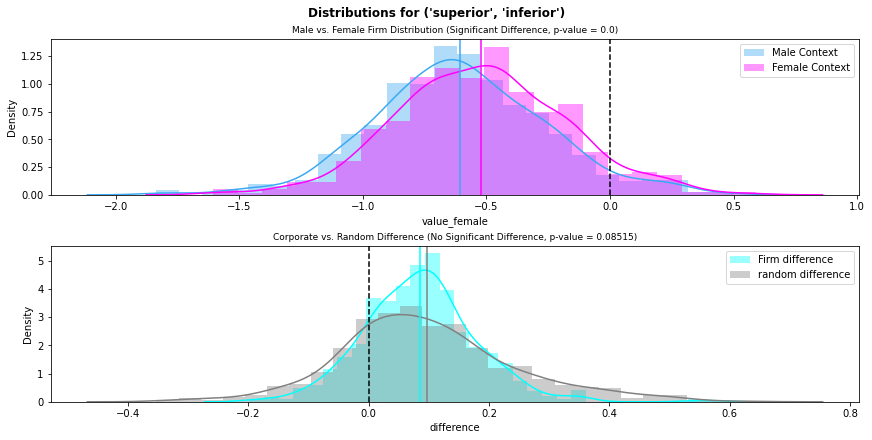

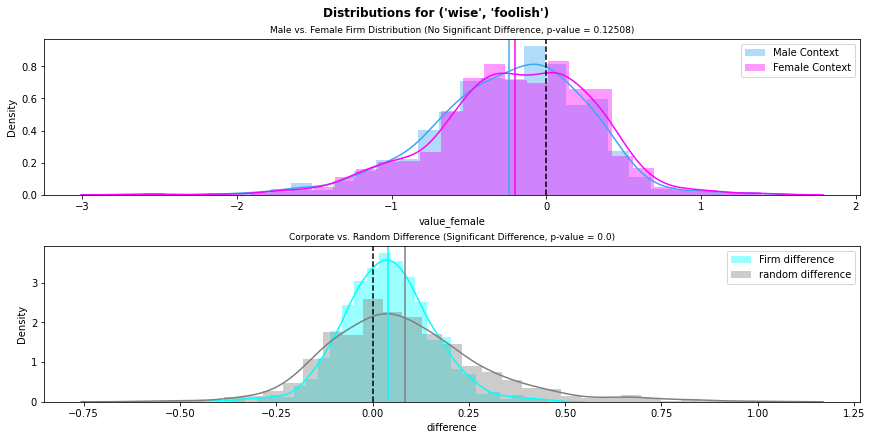

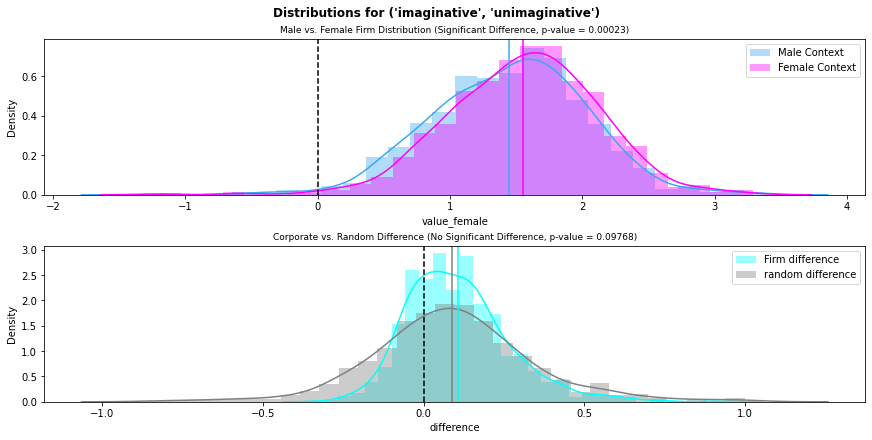

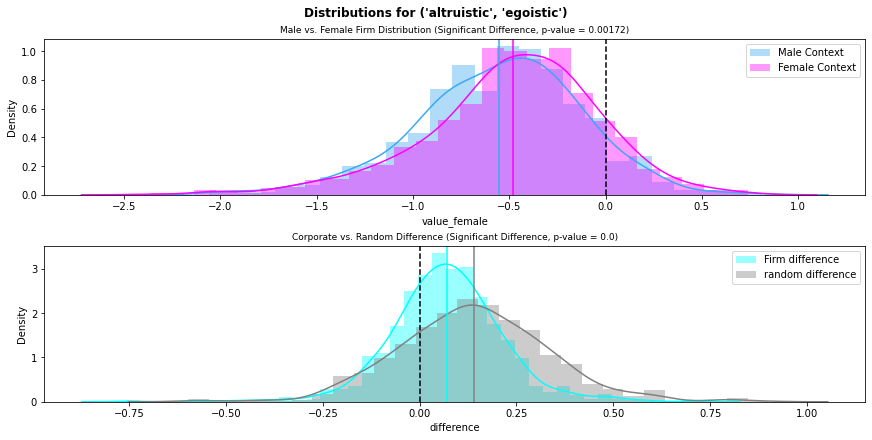

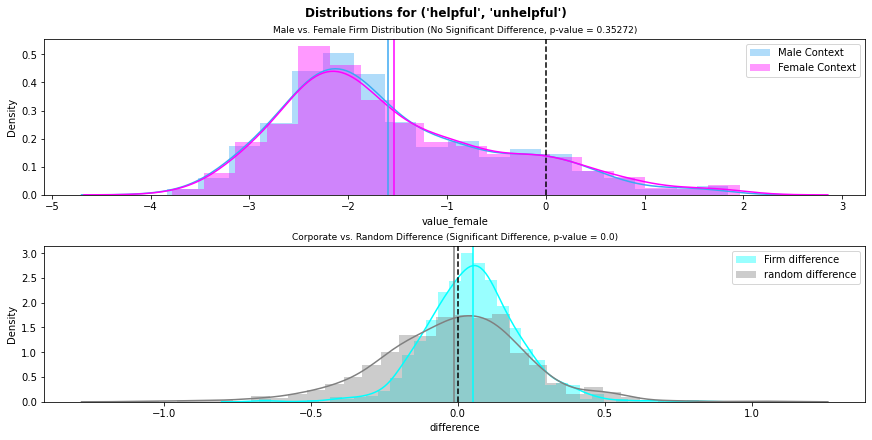

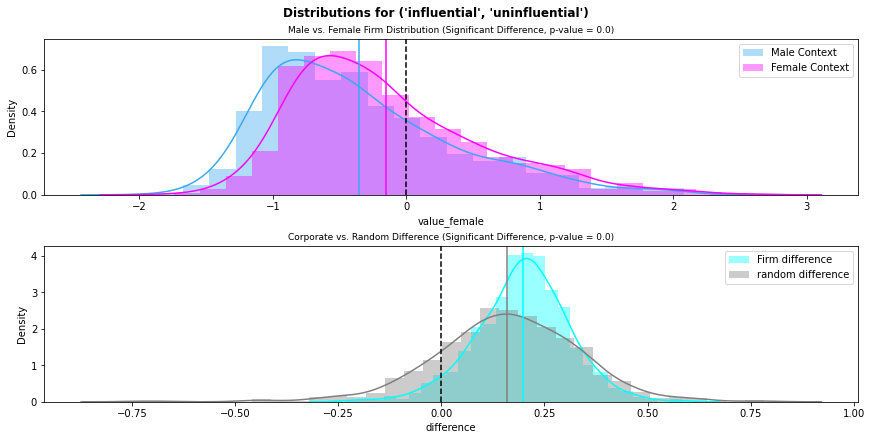

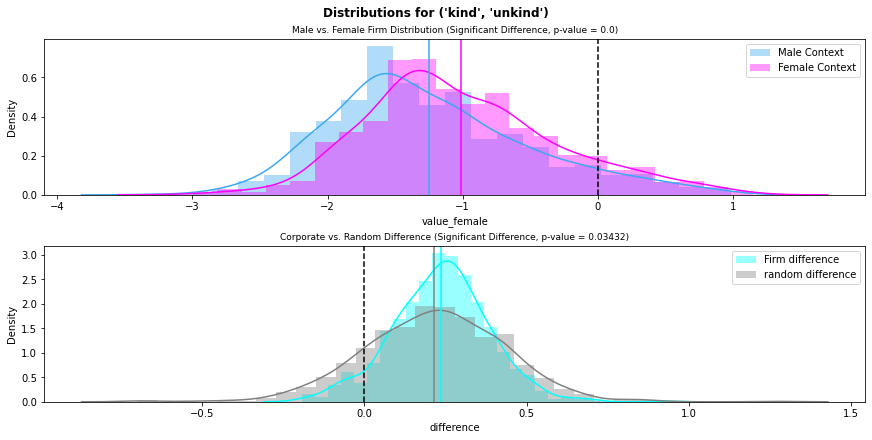

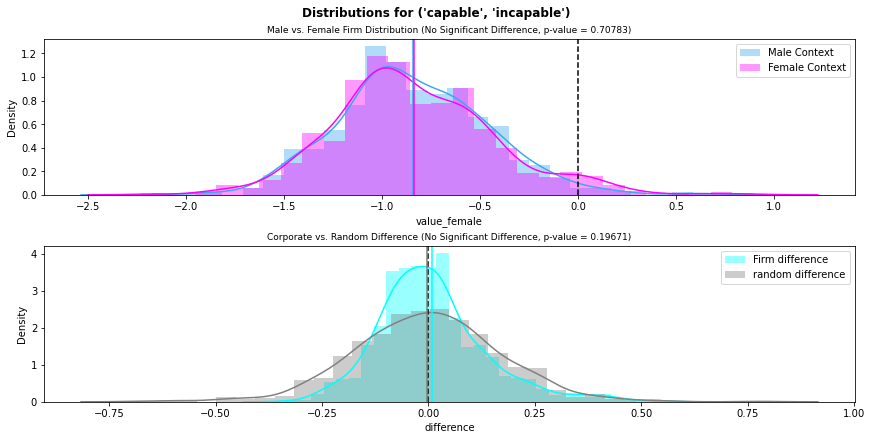

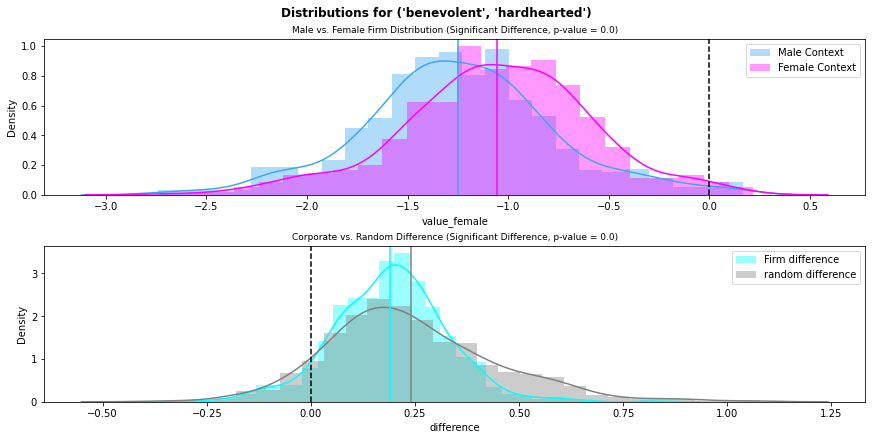

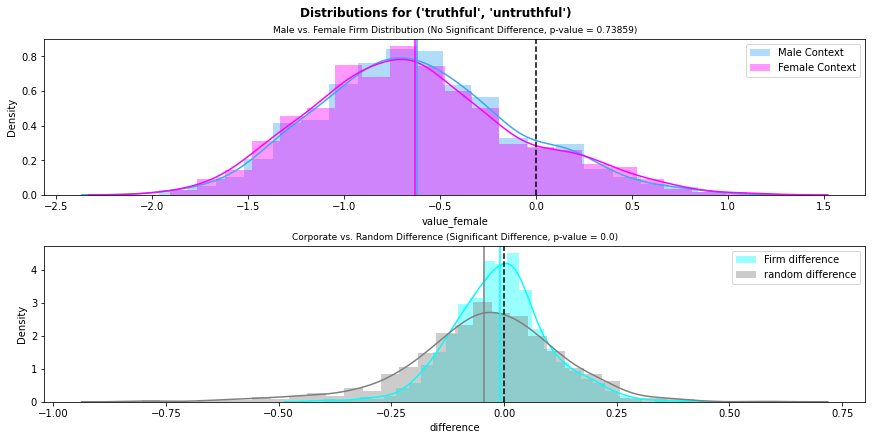

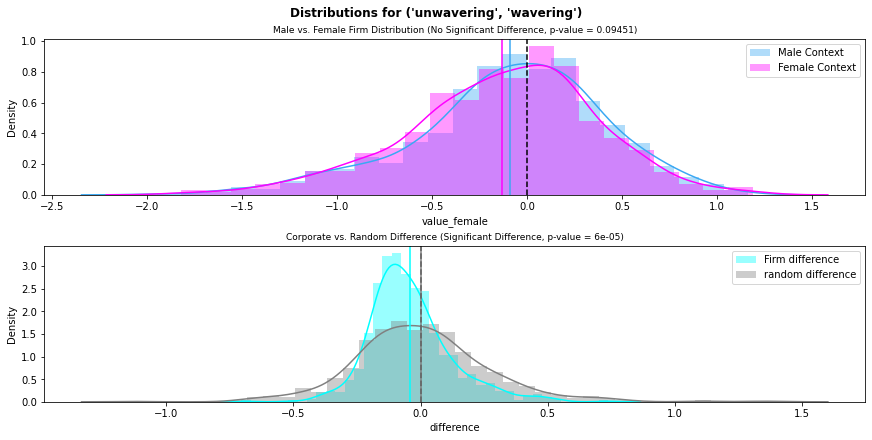

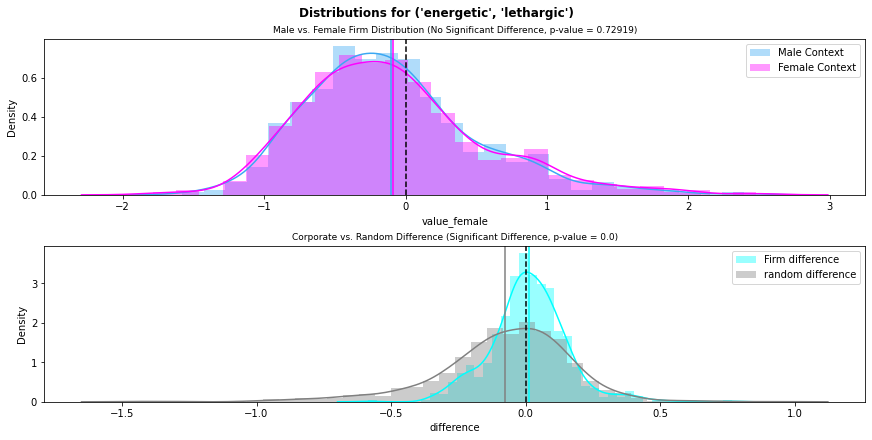

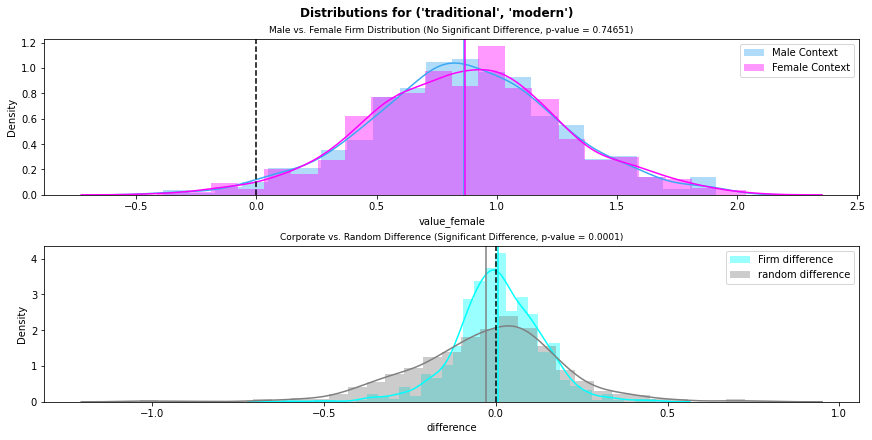

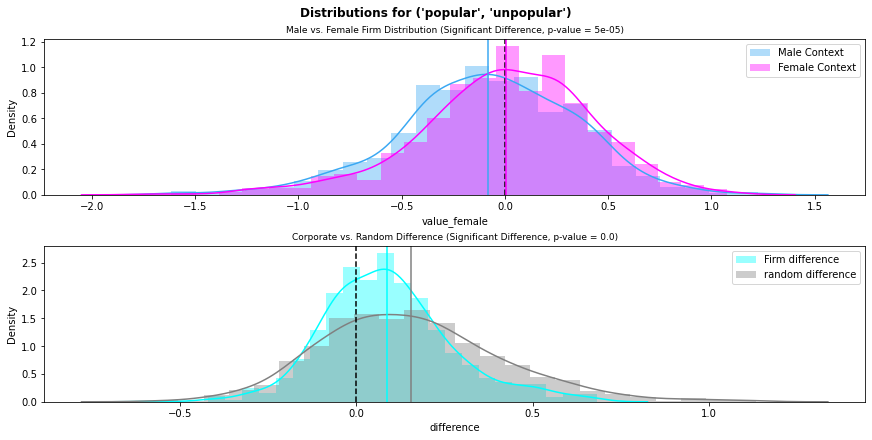

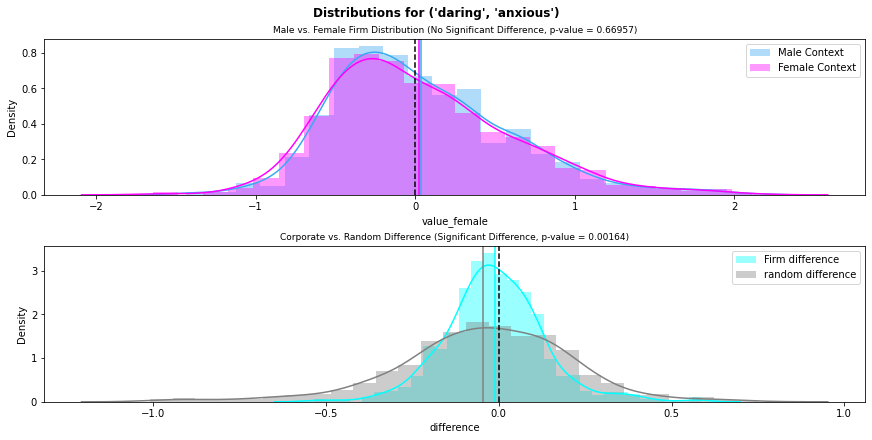

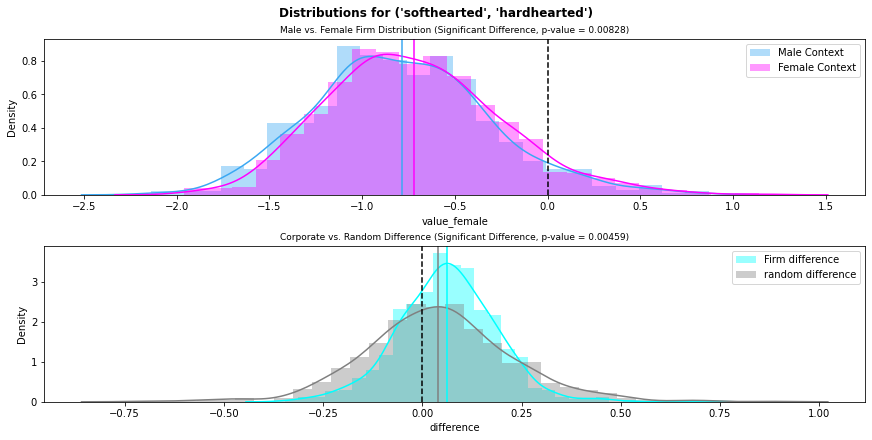

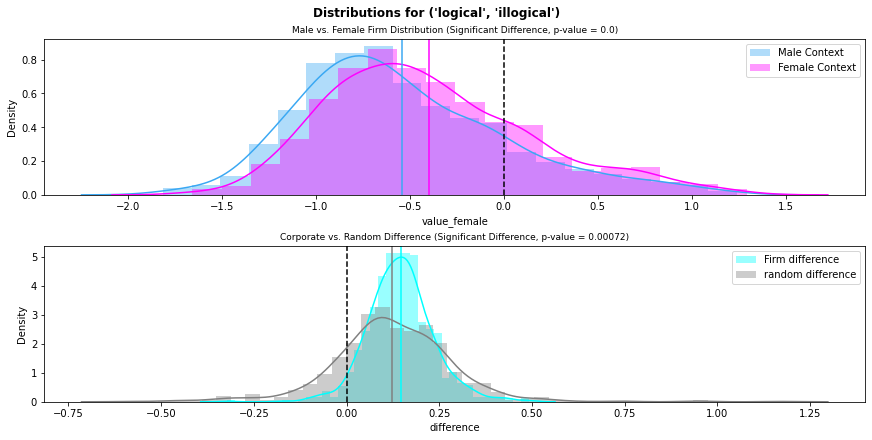

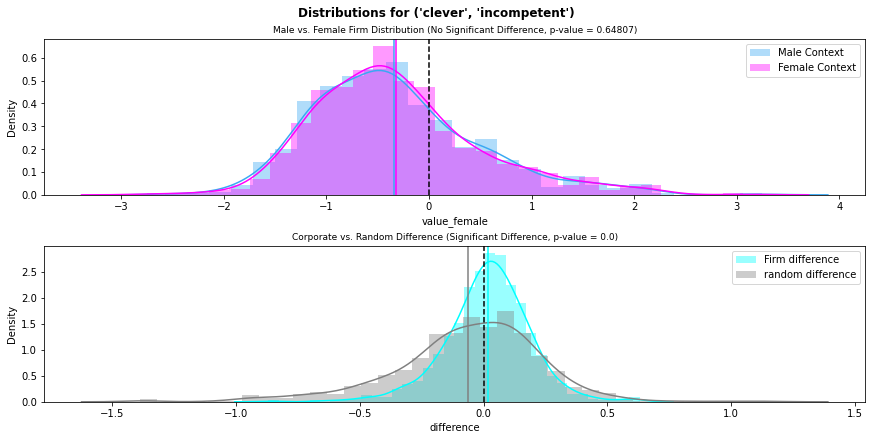

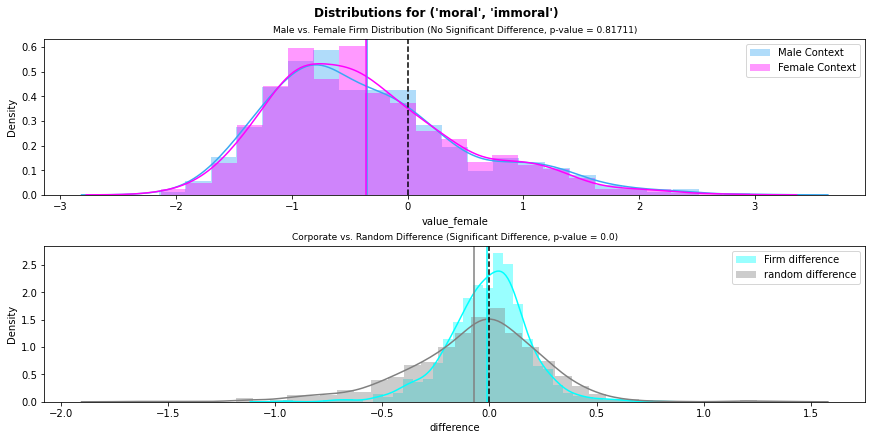

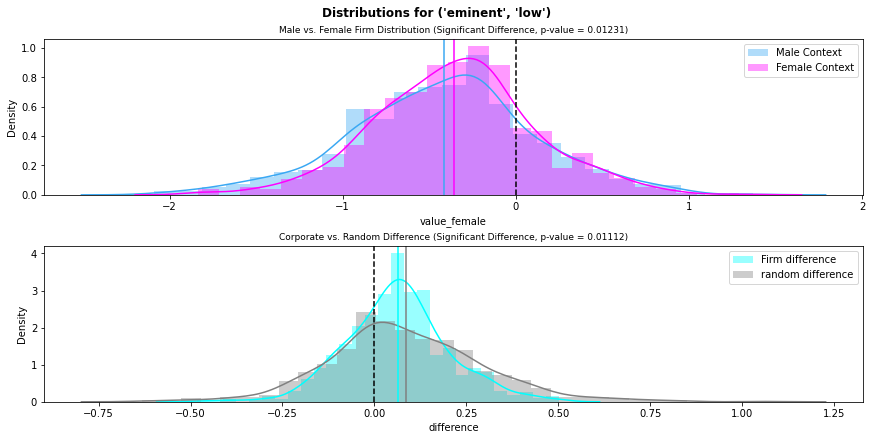

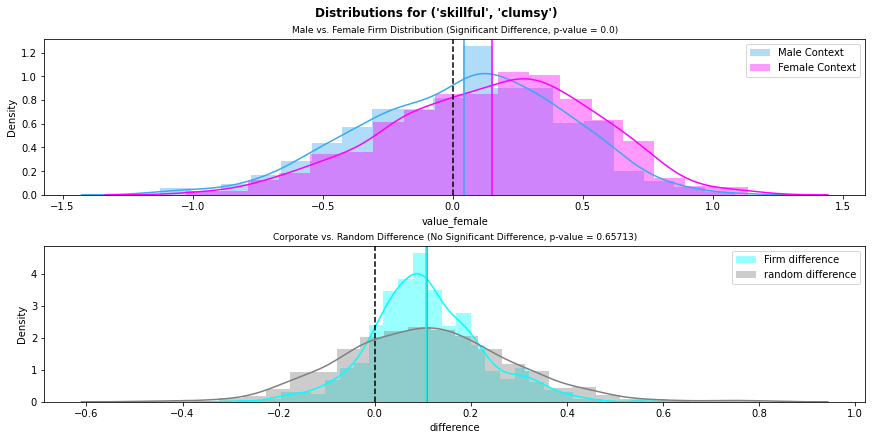

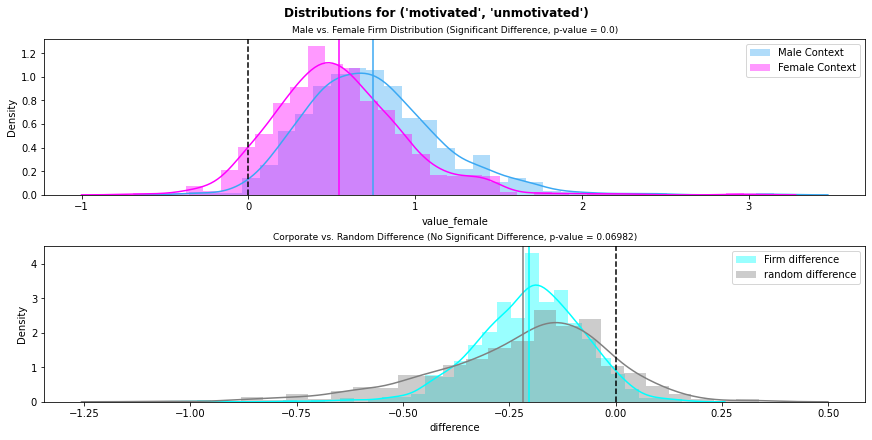

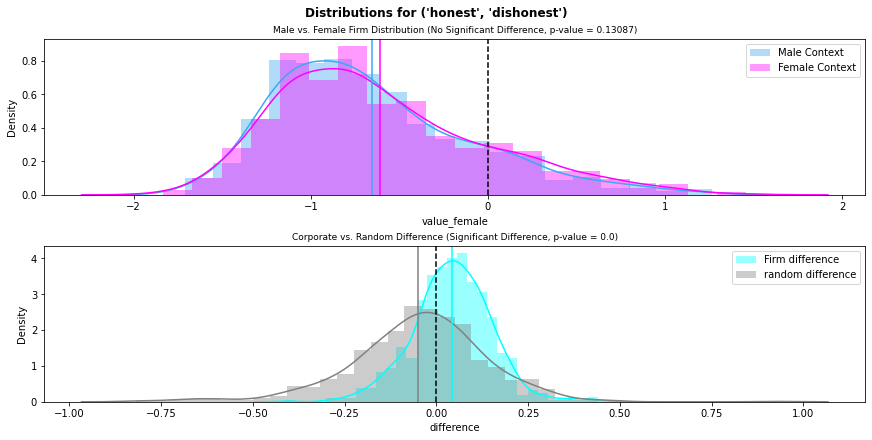

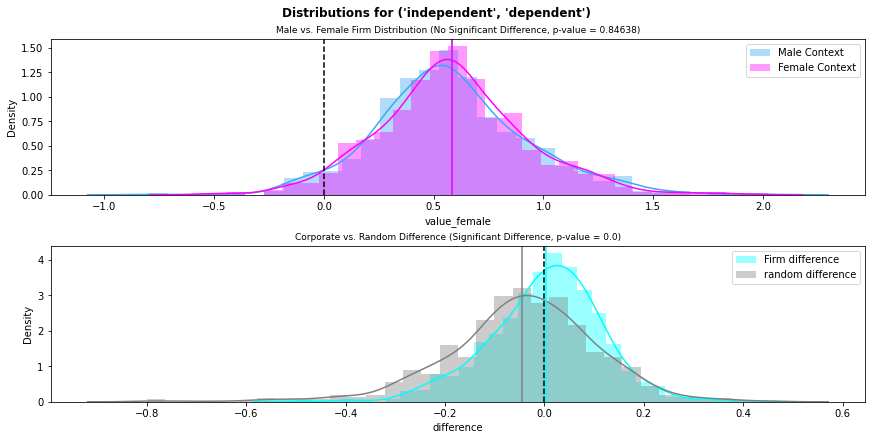

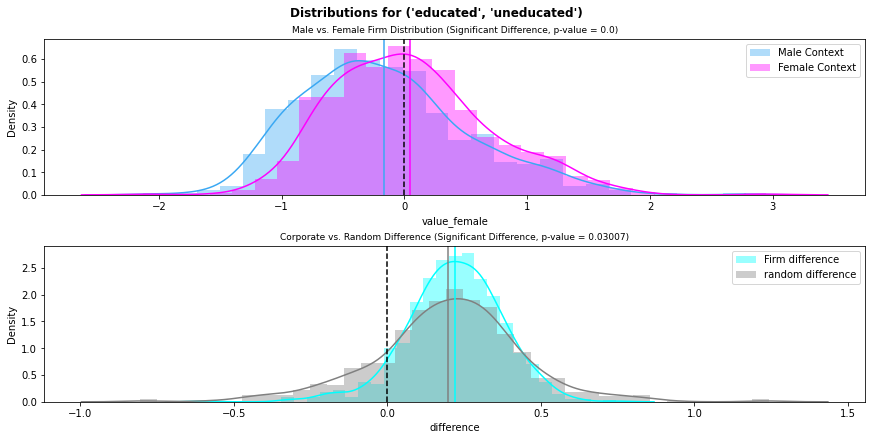

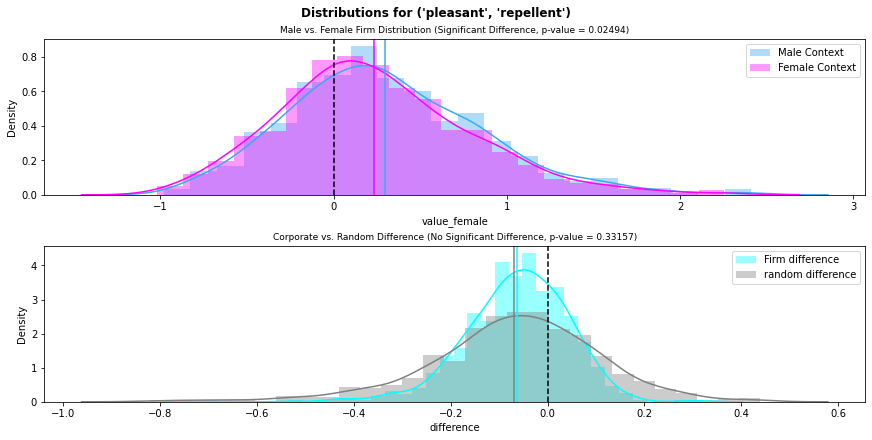

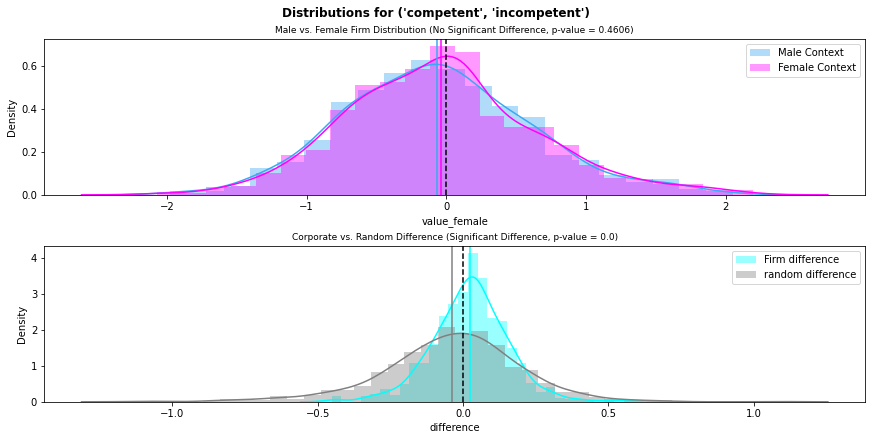

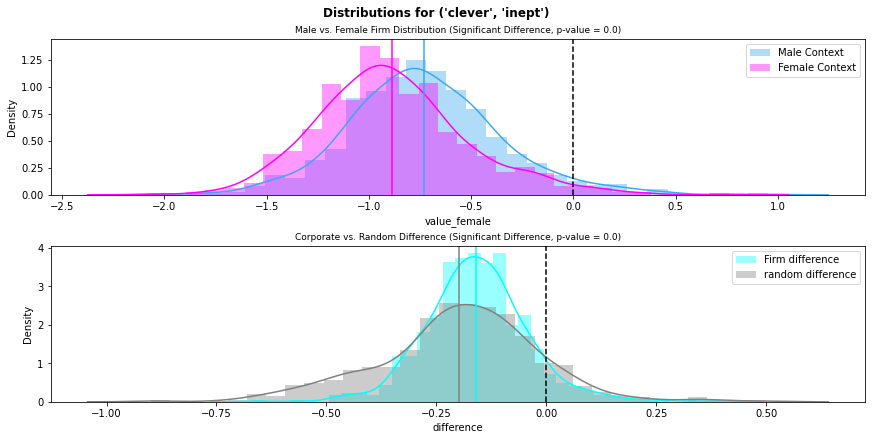

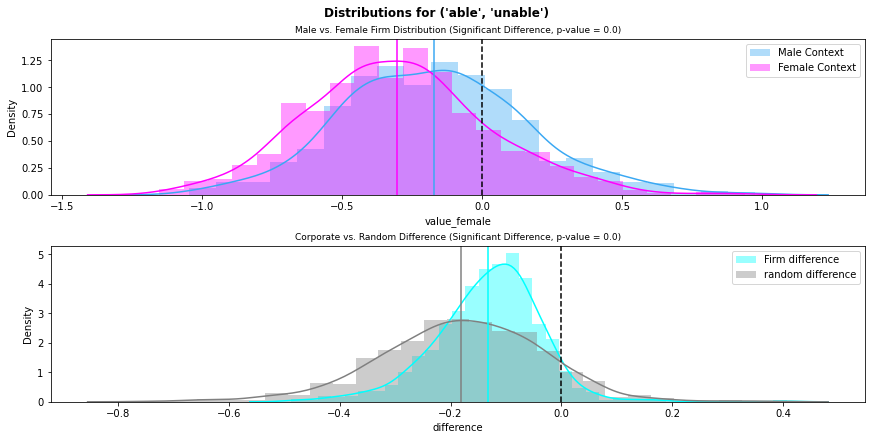

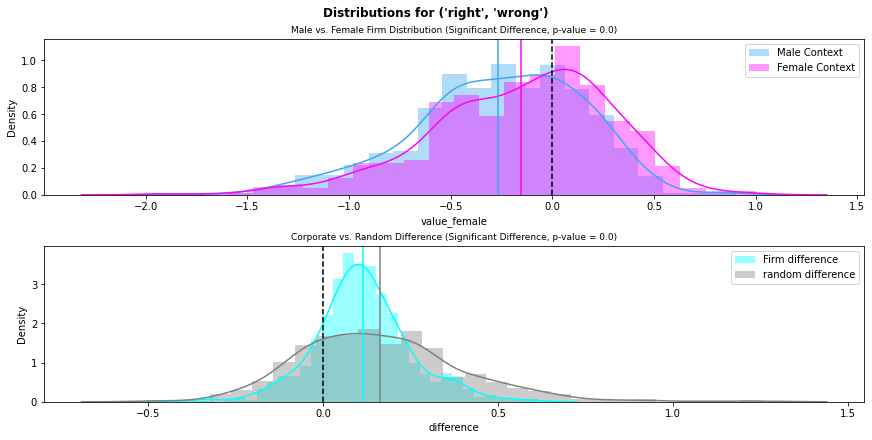

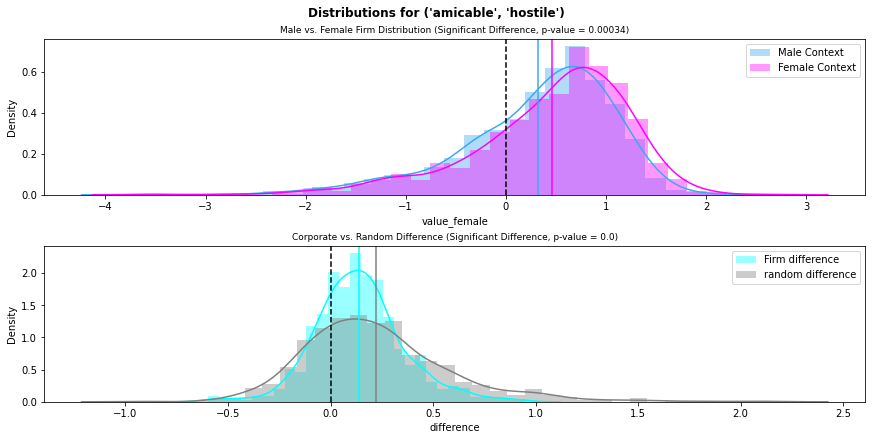

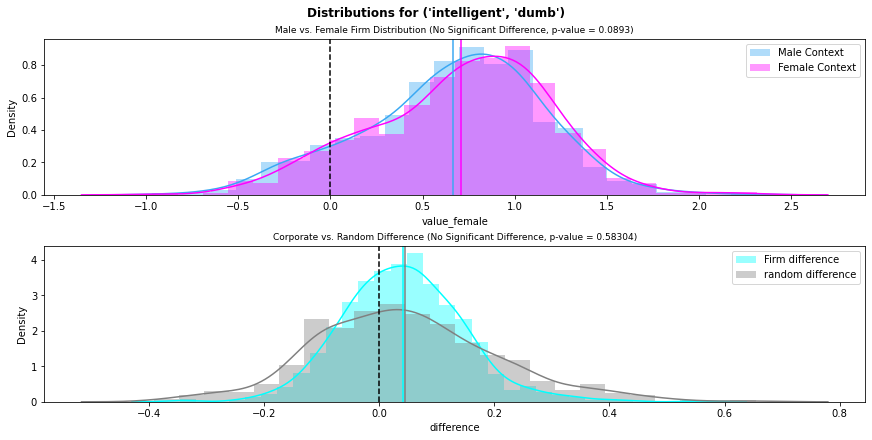

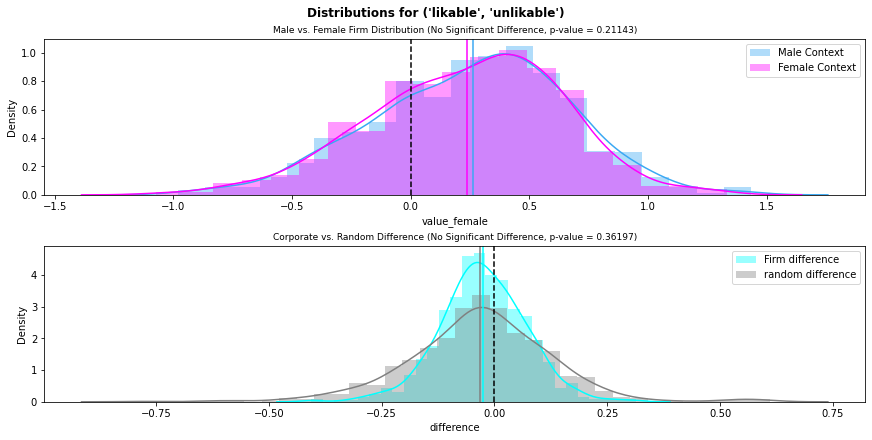

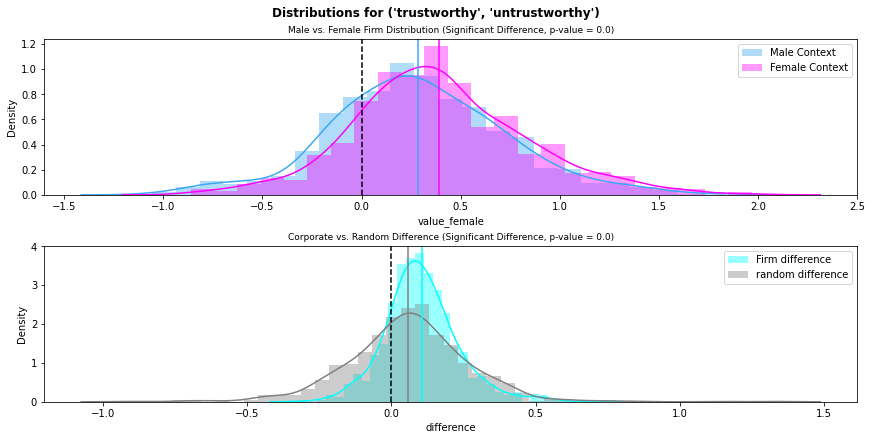

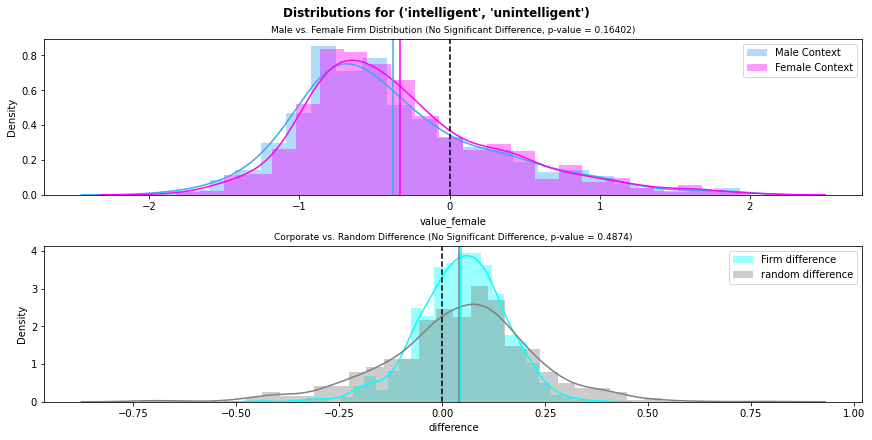

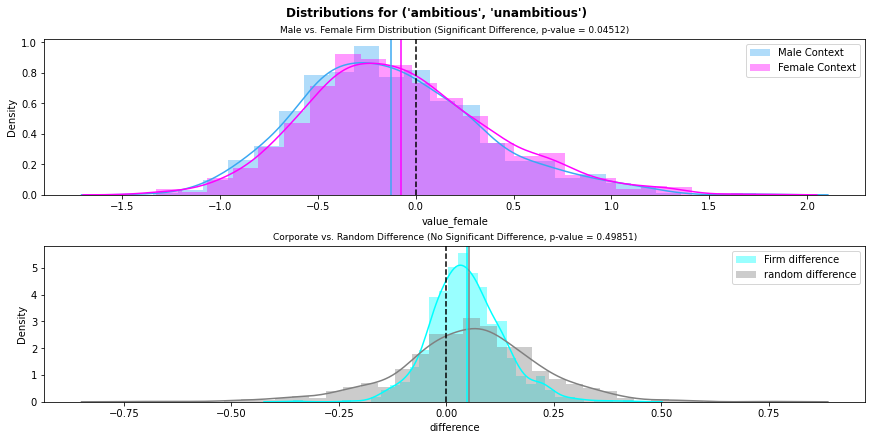

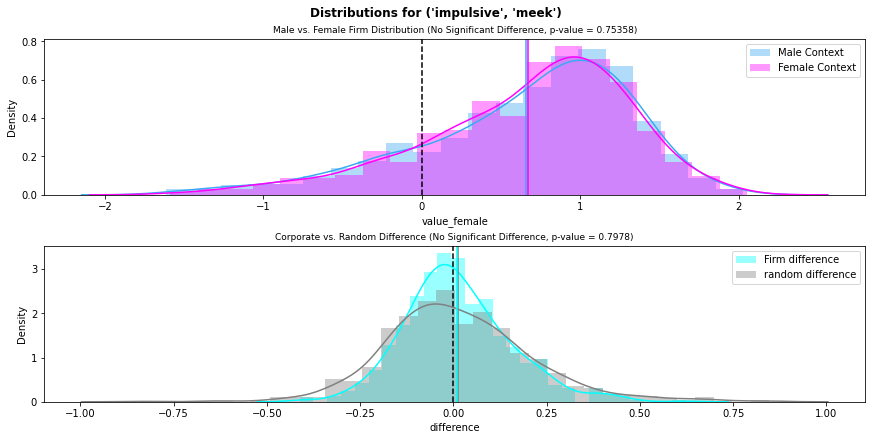

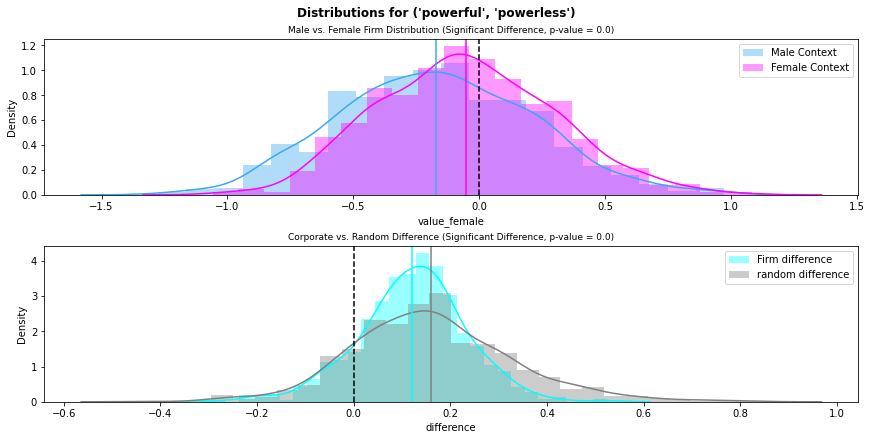

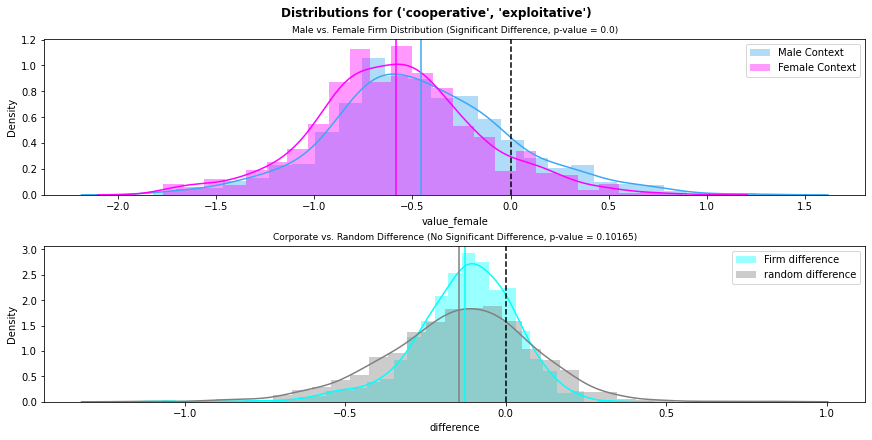

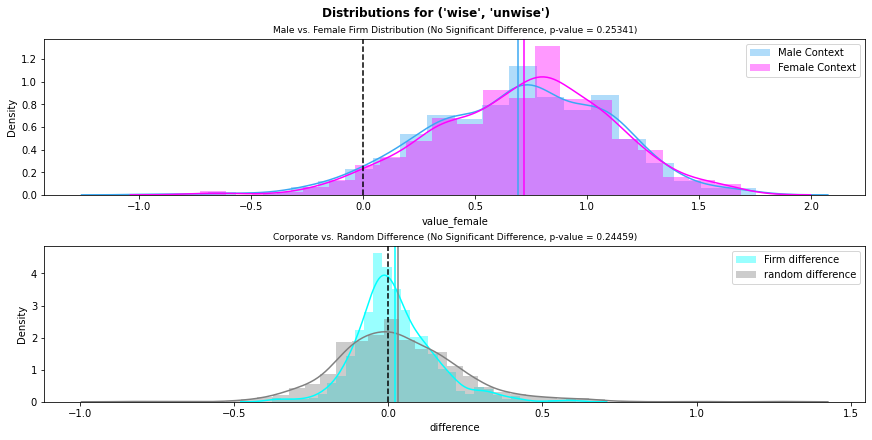

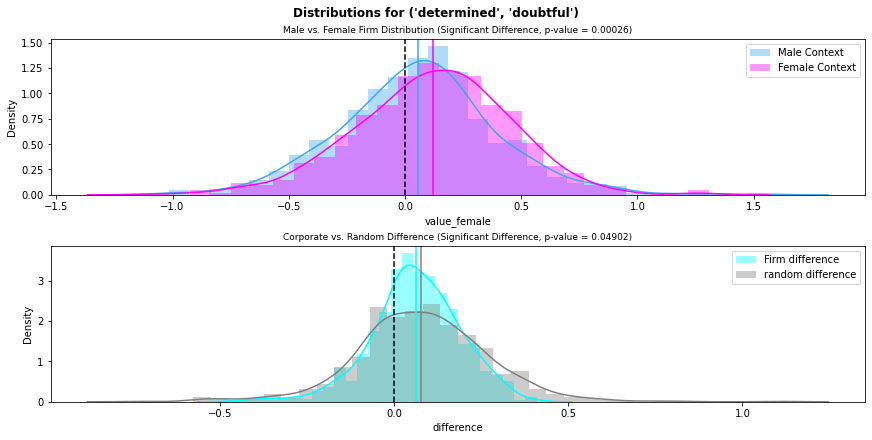

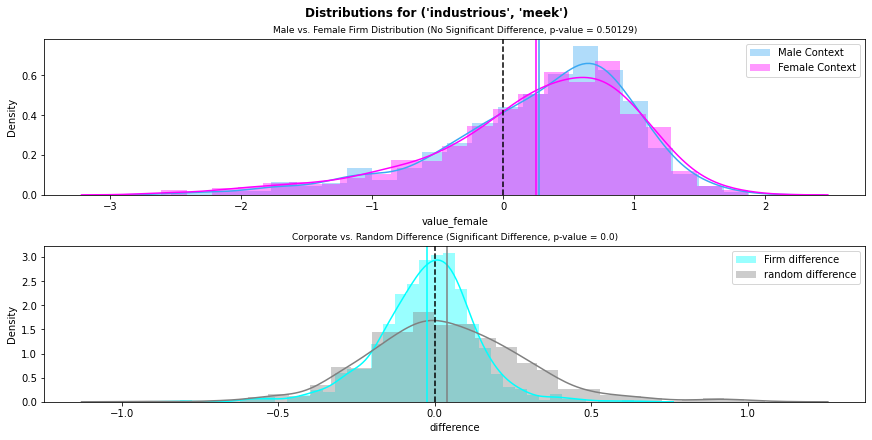

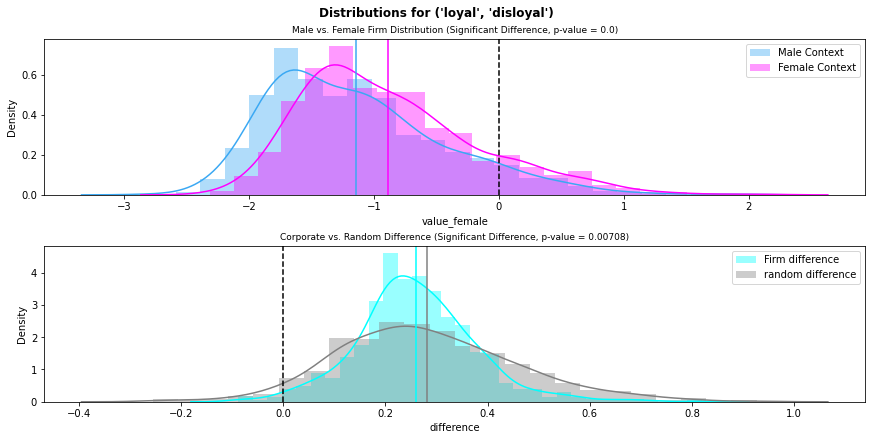

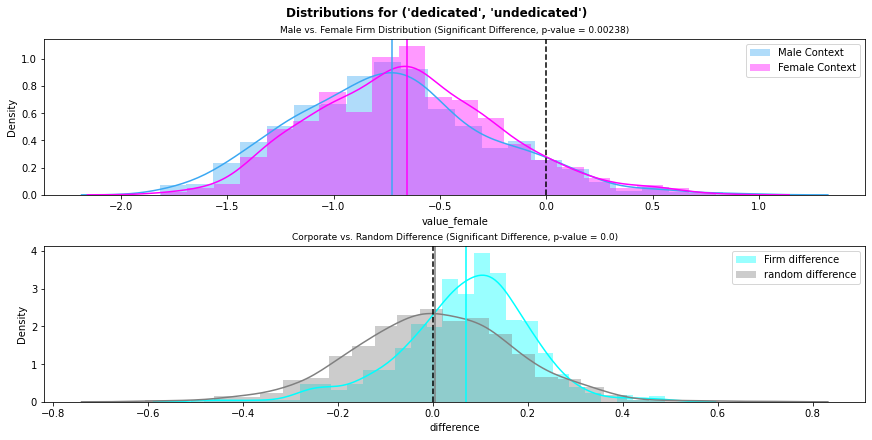

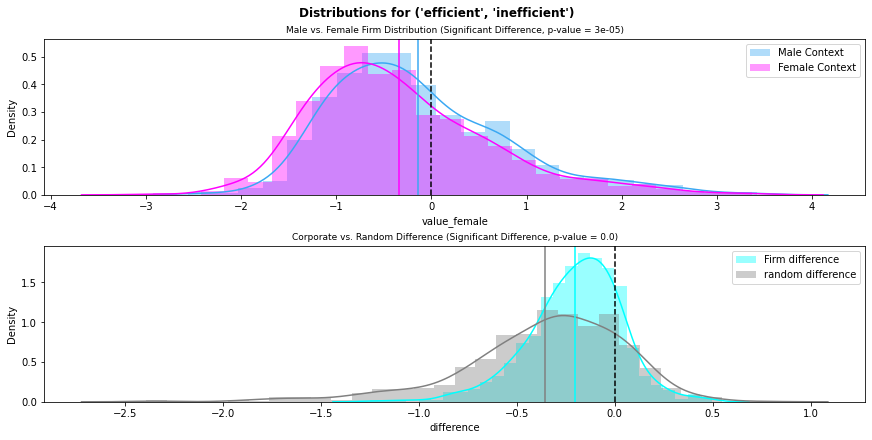

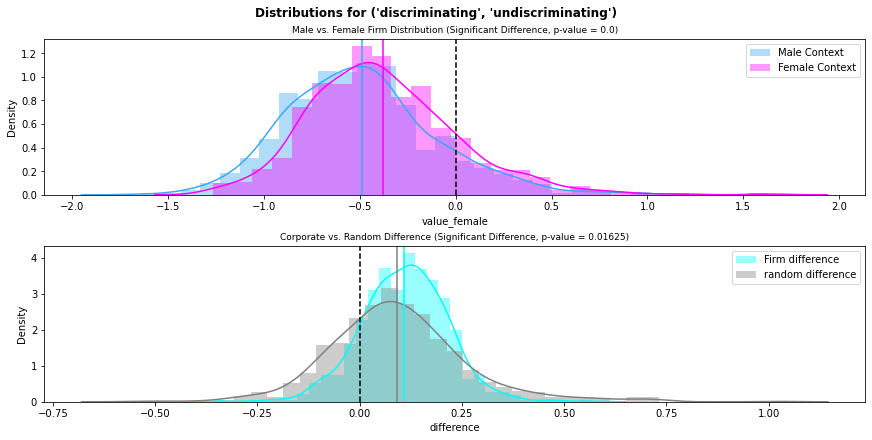

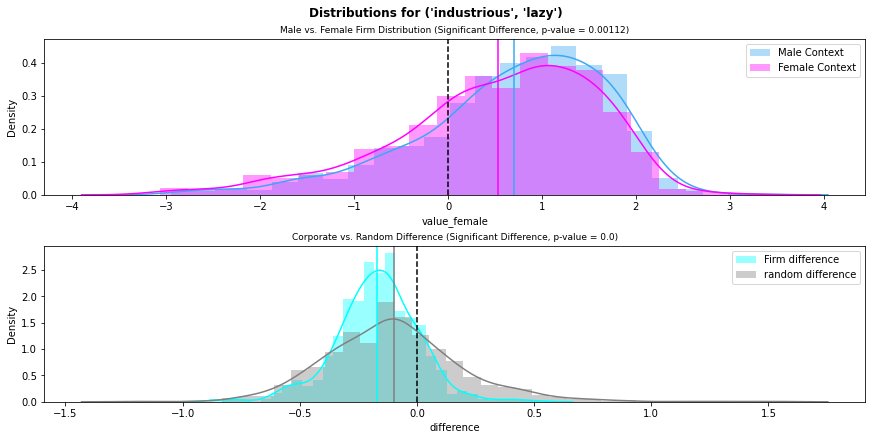

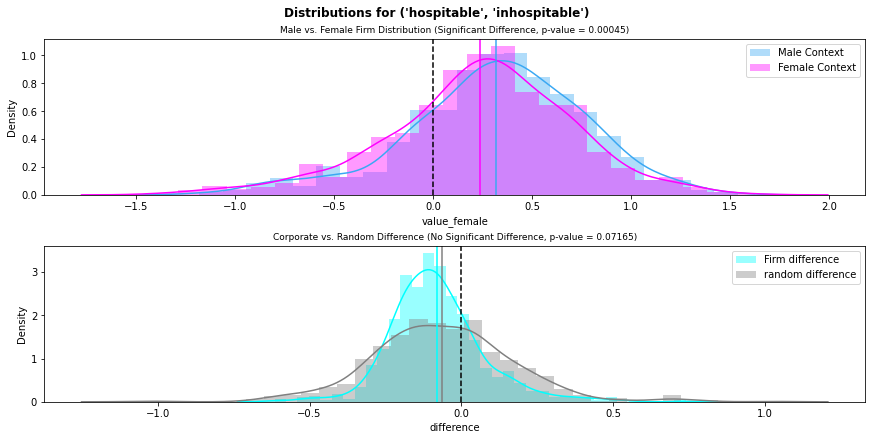

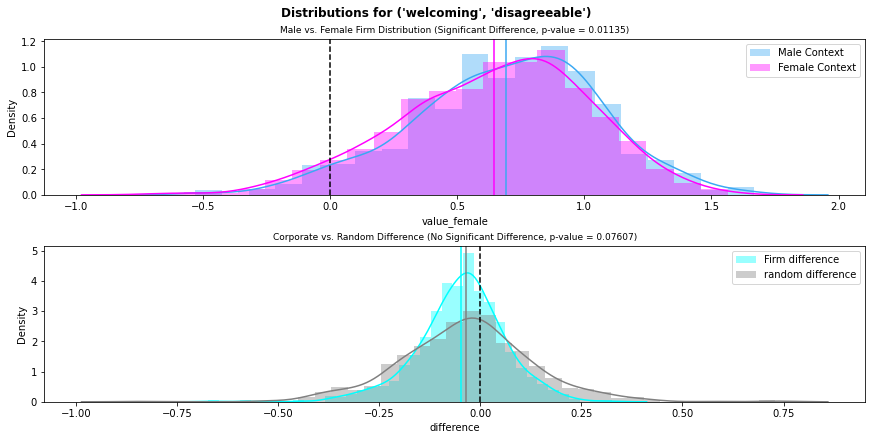

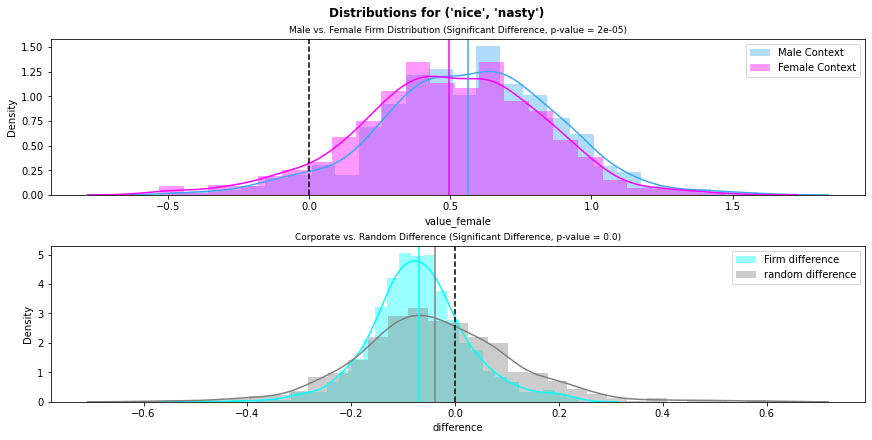

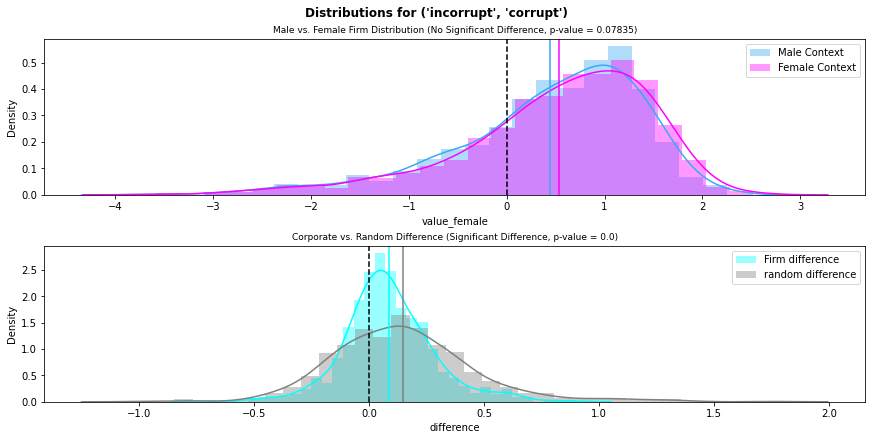

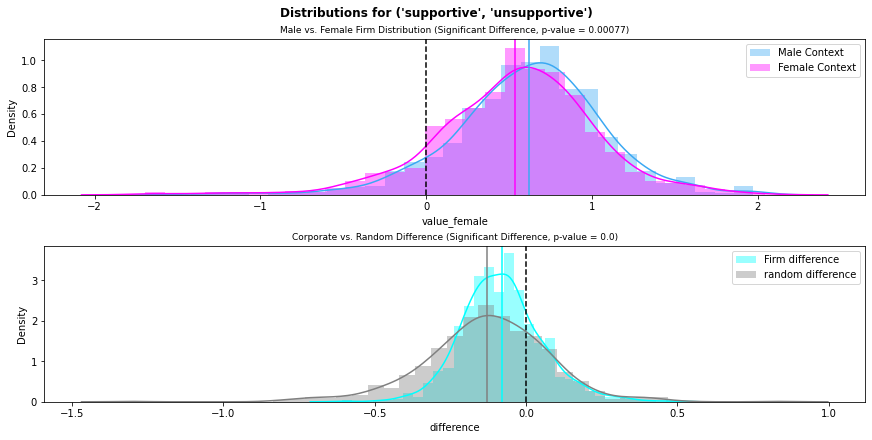

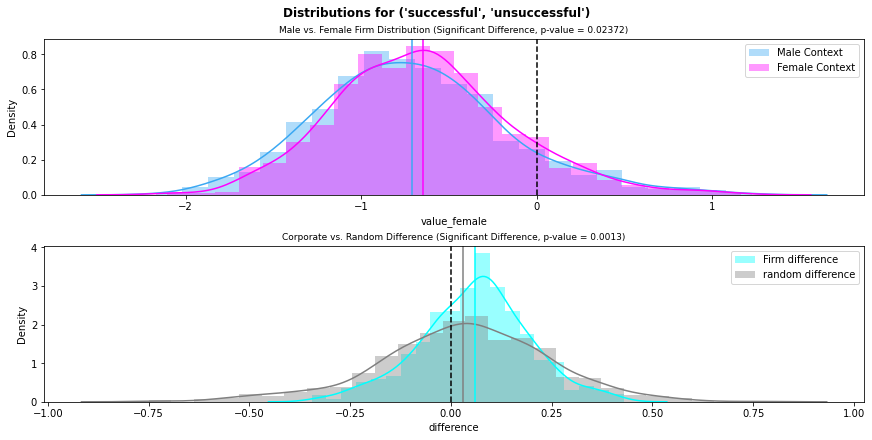

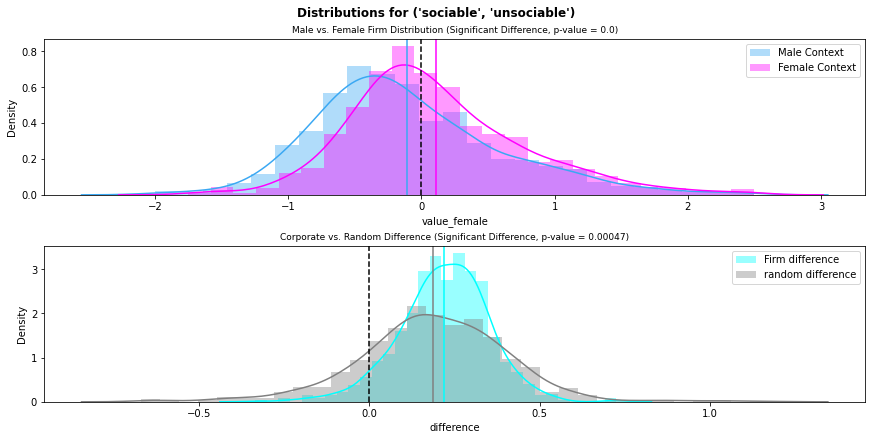

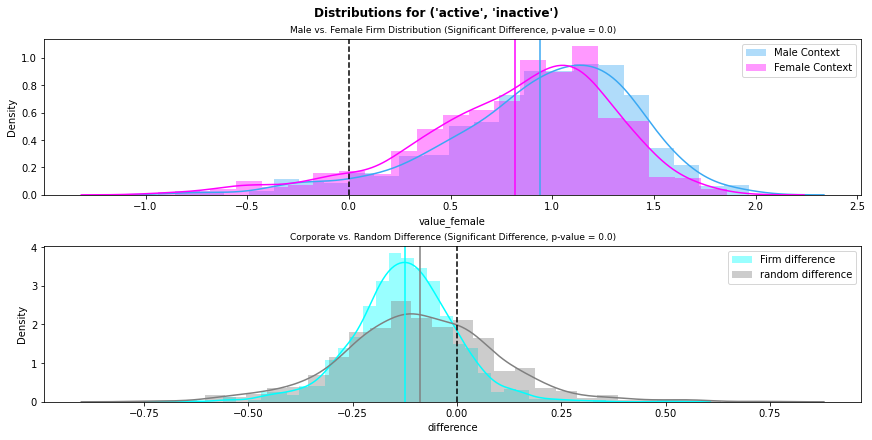

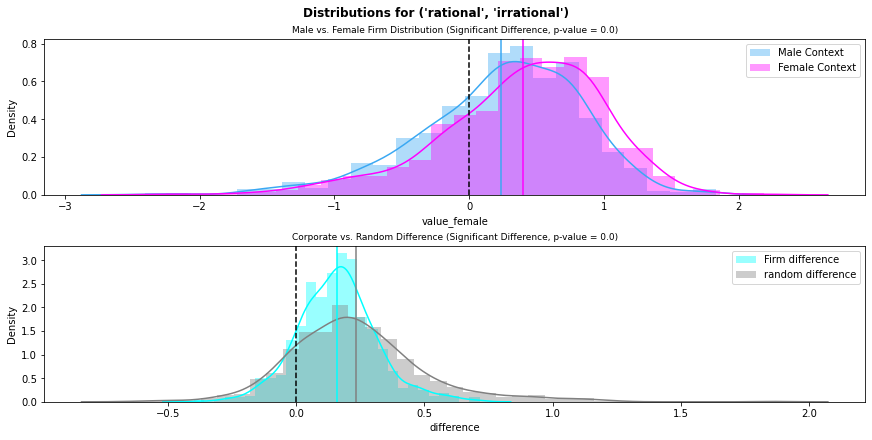

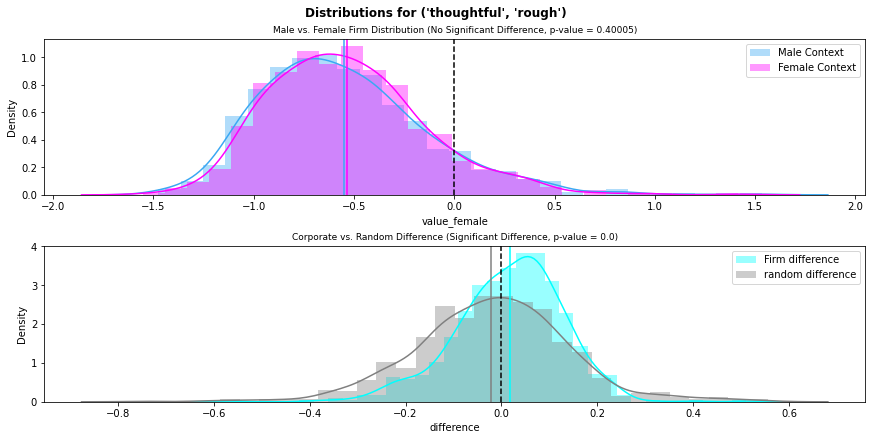

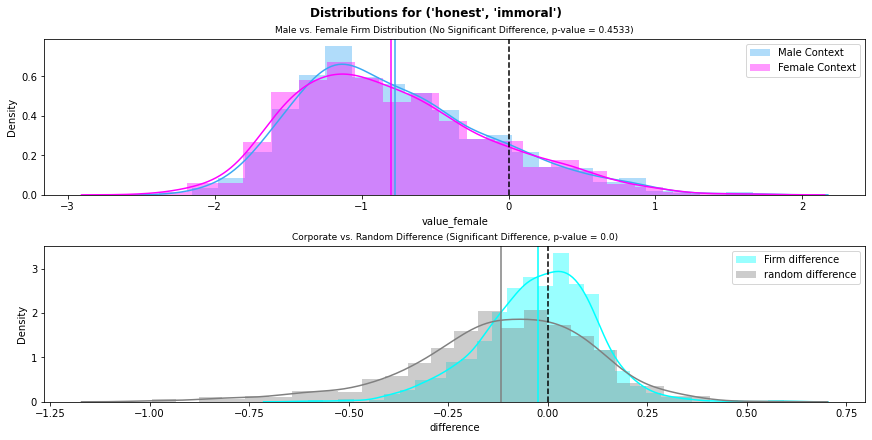

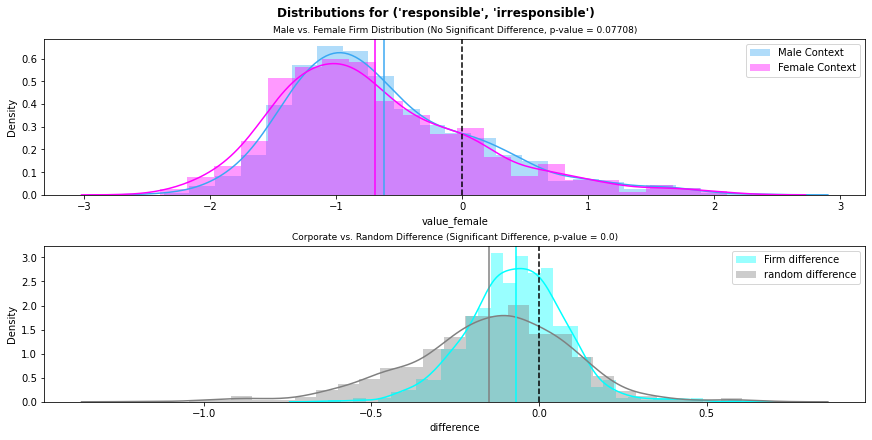

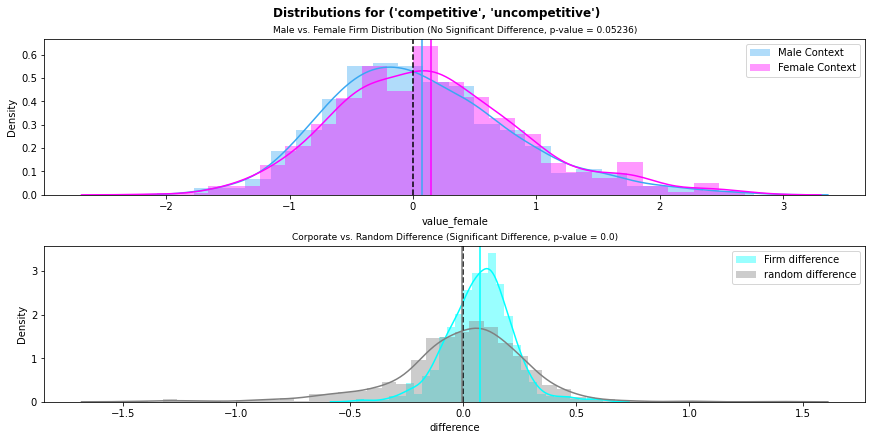

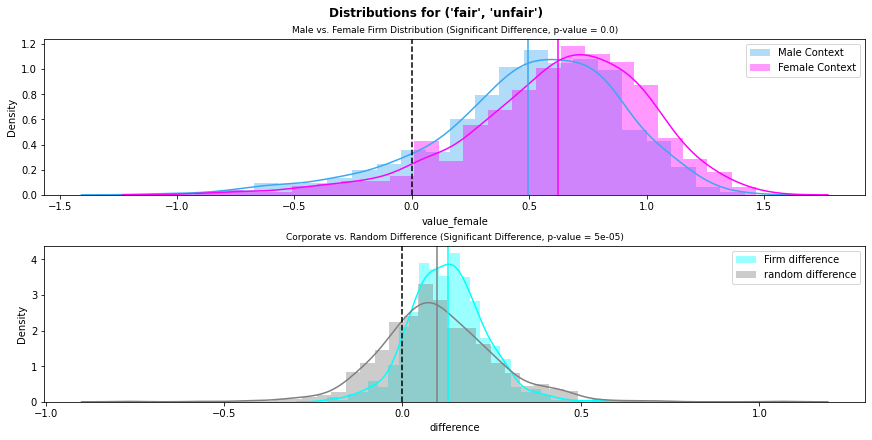

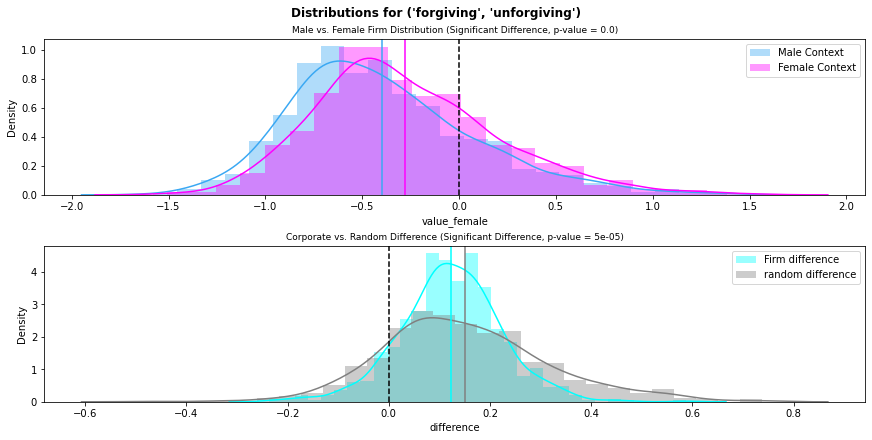

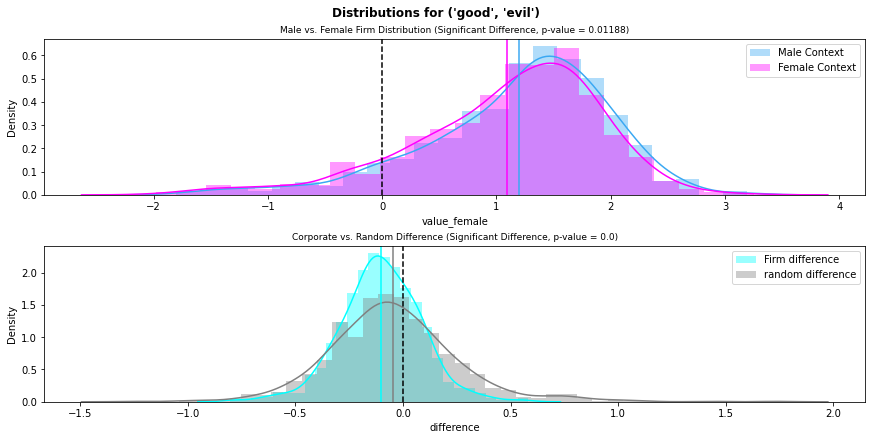

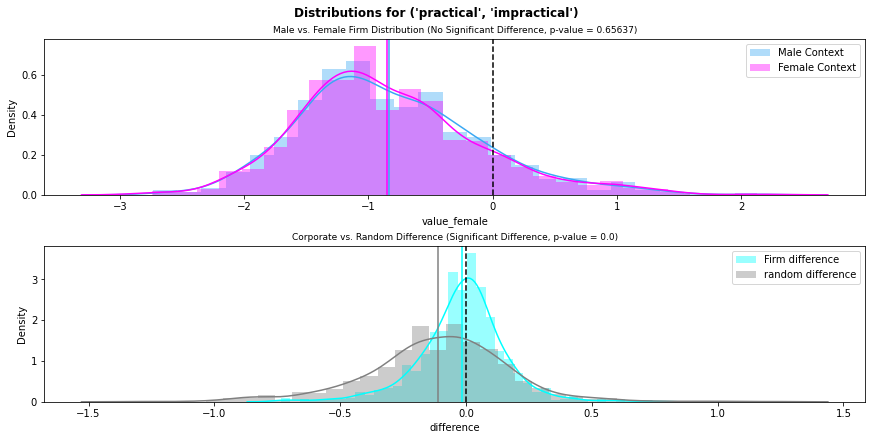

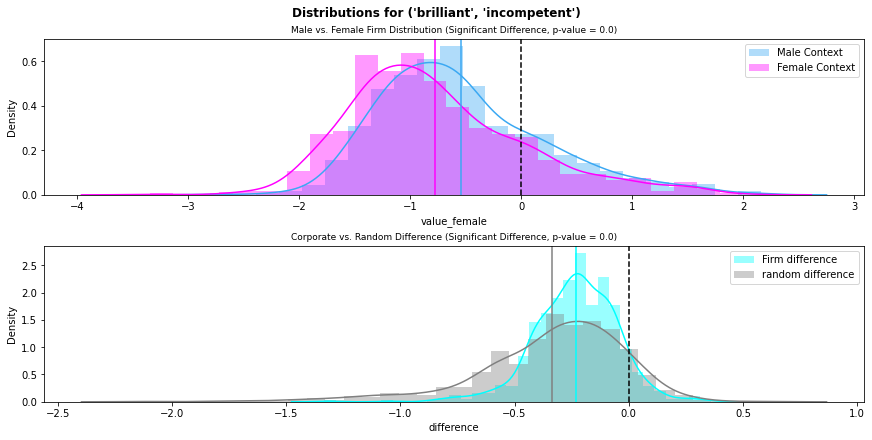

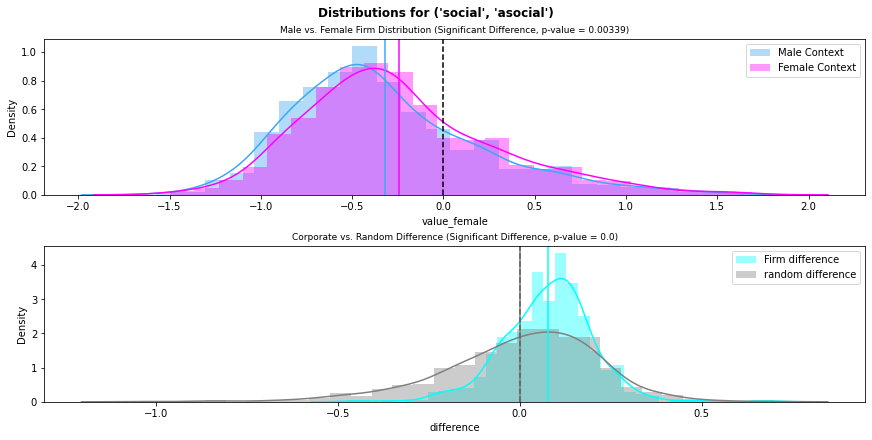

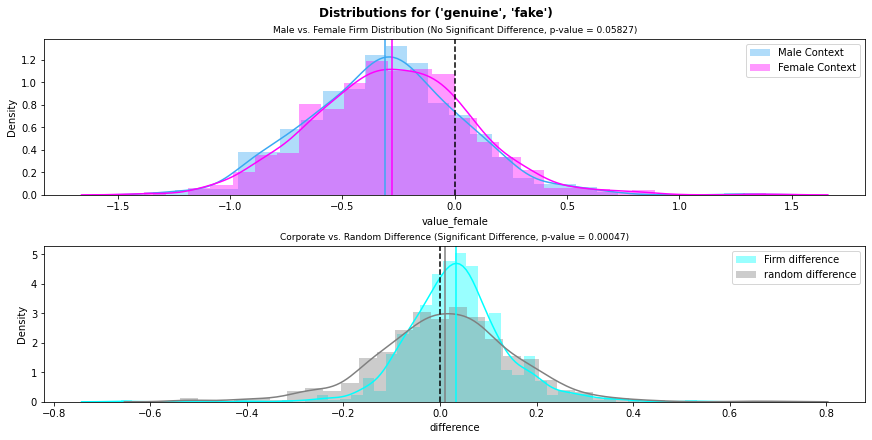

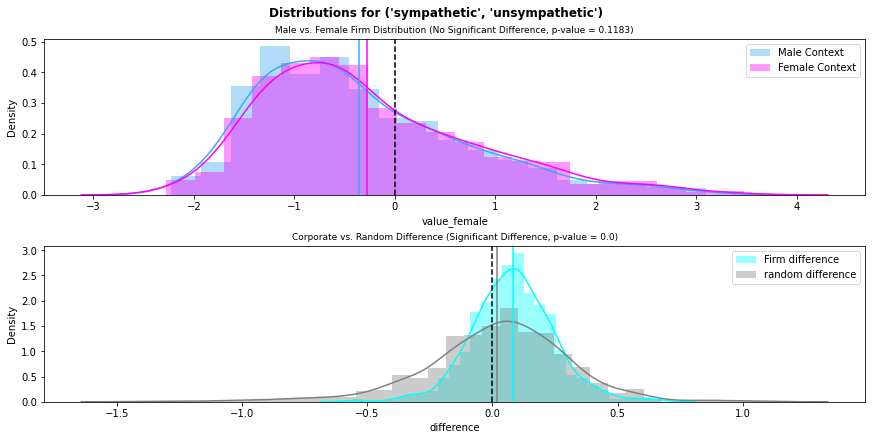

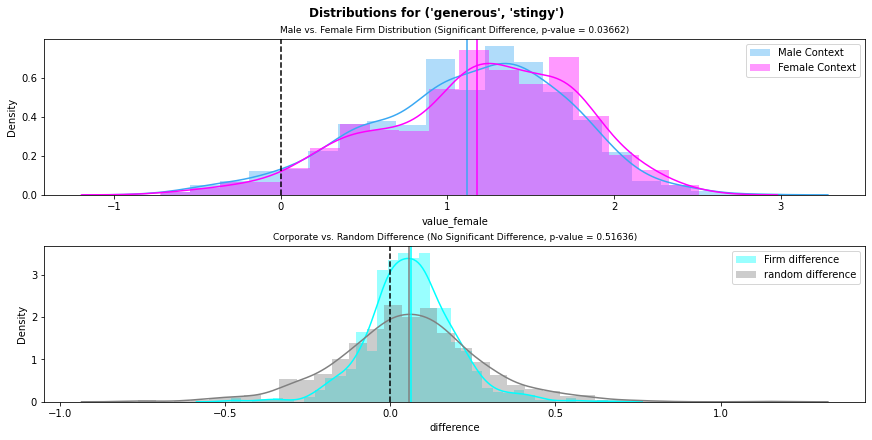

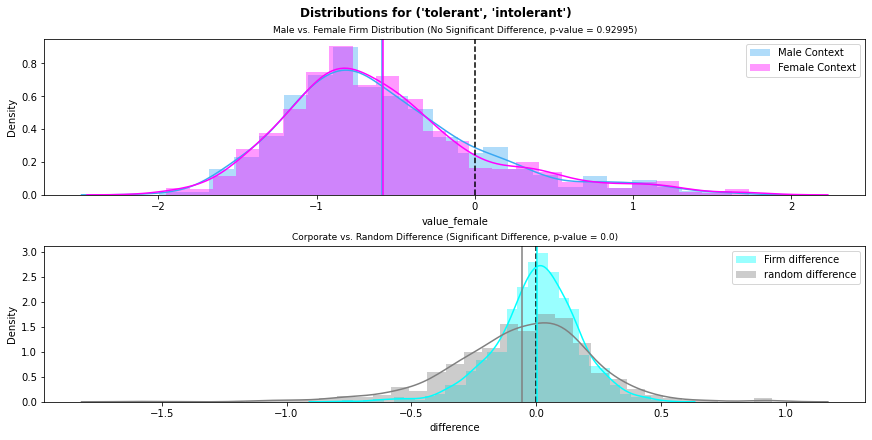

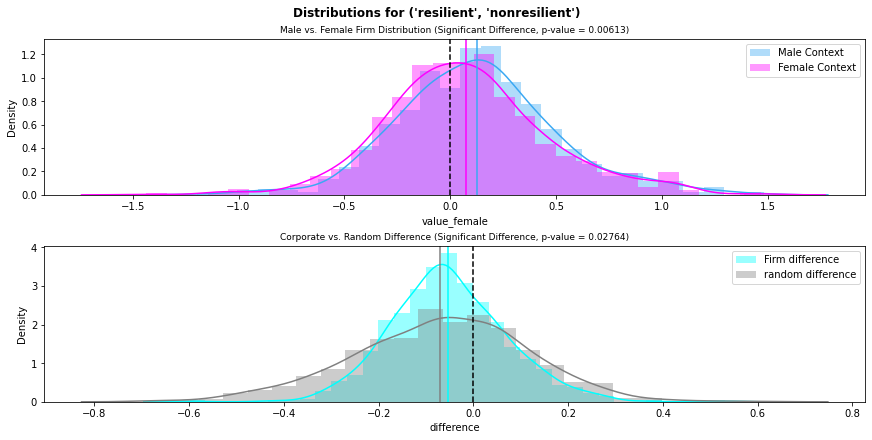

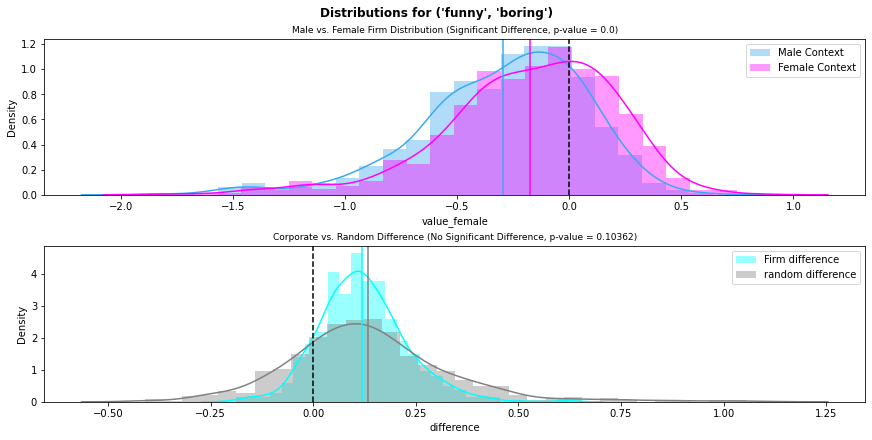

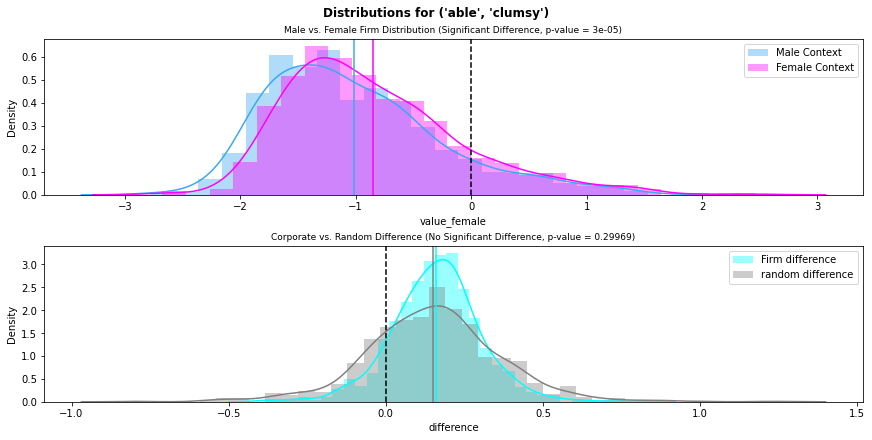

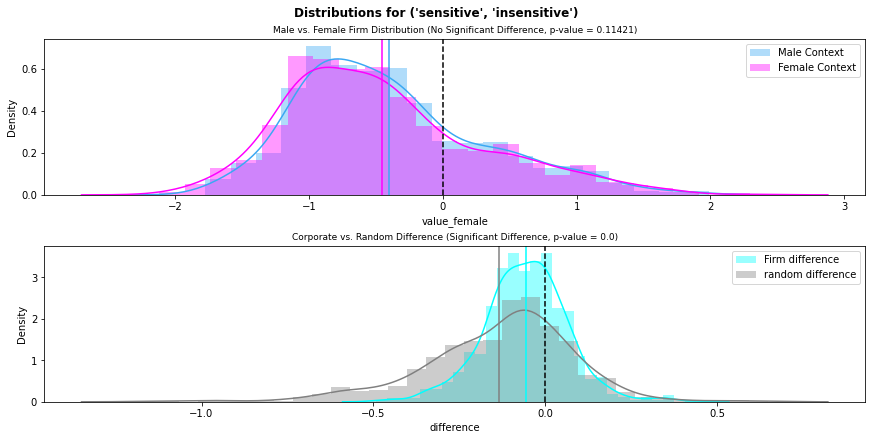

In [7]:
# Create and save plots for all dimensions. 

for dimension in all_dimensions: 
    get_dimension_distribution(company_names["Name"], str(dimension), nouns_sample, path)

### 2.2 Get p-value Overview on Dimension Level

In [10]:
considered_companies = company_names["Name"].unique()
#considered_companies = company_names[company_names["Count"] == 1]["Name"]

In [ ]:
res_table = pd.DataFrame()
res_table["Dimension"] = all_dimensions
res_table["M vs. F Firm Embedding"] = 0 
res_table["Delta Firm vs. Delta Random Embedding"] = 0
res_table["Mean Firm"] = 0
res_table["Mean Random"] = 0

# Loop through all unique dimensions. 
for dimension in tqdm(all_dimensions): 

    # Get and append p-values for dimension. 
    res = get_dimension_pvalues(considered_companies, str(dimension), nouns_sample, path)
    res_table["M vs. F Firm Embedding"].loc[res_table["Dimension"] == dimension] = round_decimals_up(res[0], 5)
    res_table["Delta Firm vs. Delta Random Embedding"].loc[res_table["Dimension"] == dimension] = round_decimals_up(res[1], 5)

    # Get mean bias values for companies. 
    company_res = []

    for company in considered_companies: 
        comparison = pd.read_csv(f"{path}{company}.csv")
        comparison = comparison.groupby("tuple", as_index = False).mean()
        company_res.append(float(comparison[comparison["tuple"] == str(dimension)]["female-male"]))

    res_table["Mean Firm"].loc[res_table["Dimension"] == dimension] = (sum(company_res) / len(company_res))

    # Get mean bias values for random nouns. 
    noun_res = []

    for noun in nouns_sample: 
        comparison = pd.read_csv(f"{path}{noun}.csv")
        comparison = comparison.groupby("tuple", as_index = False).mean()
        noun_res.append(float(comparison[comparison["tuple"] == str(dimension)]["female-male"]))

    res_table["Mean Random"].loc[res_table["Dimension"] == dimension] = (sum(noun_res) / len(noun_res))
    res_table["Mean Firm vs. Mean Random"] = res_table["Mean Firm"] - res_table["Mean Random"]

In [13]:
res_table.head()

Dimension  M vs. F Firm Embedding  \
0          (confident, shy)                 0.49882   
1           (open, distant)                 0.00000   
2    (creative, uncreative)                 0.13082   
3  (aggressive, submissive)                 0.10145   
4      (sincere, insincere)                 0.42720   

   Delta Firm vs. Delta Random Embedding  Mean Firm  Mean Random  \
0                                0.80673  -0.048980    -0.052544   
1                                0.04376  -0.217185    -0.245974   
2                                0.00255   0.043751     0.017690   
3                                0.00023   0.062031     0.012314   
4                                0.00000   0.072039    -0.029660   

   Mean Firm vs. Mean Random  
0                   0.003564  
1                   0.028789  
2                   0.026061  
3                   0.049717  
4                   0.101699

In [14]:
sign_level = 0.05
decimals = 3

print(f"""Significant Difference on Firm Level: {round((len(res_table[res_table.iloc[:, 1] < sign_level]) / len(res_table))*100, decimals)} %\n
Signficant difference from random: {round((len(res_table[res_table.iloc[:, 2] < sign_level]) / len(res_table))*100, decimals)} %\n
Both significant difference on firm level and significant difference from random: {round((len(res_table[(res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level)]) / len(res_table))*100, decimals)} %\n
Dimensions Favoring Male Context for firm embedding: {round((len(res_table[res_table.iloc[:, 3] > 0]) / len(res_table))*100, decimals)} %\n
Firm context more biased than random context: {round((len(res_table[res_table.iloc[:, 3] > res_table.iloc[:, 4]]) / len(res_table))*100, decimals)} %
""")

Significant Difference on Firm Level: 56.436 %

Signficant difference from random: 79.208 %

Both significant difference on firm level and significant difference from random: 42.574 %

Dimensions Favoring Male Context for firm embedding: 62.376 %

Firm context more biased than random context: 65.347 %



### 2.3 Get Dictionary Overview

In [12]:
# Read and prepare dictionaries. 

dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries["tuple"] = list(zip(dictionaries["Term1"].astype(str), dictionaries["Term2"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

unique_dictionaries = dictionaries["Dictionary"].unique()
unique_dictionaries.sort()

In [13]:
def get_dictionary_average(target_list, scope):
    
    result_dict = {}
    result_dict["Name"] = []

    for dictionary in unique_dictionaries: 
        result_dict[f"{dictionary}_Male"] = []
        result_dict[f"{dictionary}_Female"] = []
        result_dict[f"{dictionary}_Female-Male"] = []

    result = pd.DataFrame(result_dict)
    
    for name in target_list: 
        comparison = pd.read_csv(f"{path}{name}.csv", index_col = 0)
        comparison = comparison.sort_index()
        comparison = pd.concat([comparison, dictionaries], axis=1) 

        comparison = comparison.groupby("Dictionary", as_index = False, ).mean()
        comparison = comparison.iloc[:,-3:]
        values = [item for sublist in comparison.values for item in sublist]
        values.insert(0, name)
        result.loc[len(result)] = values 
           
    if scope == "full":
        return result 
    
    if scope == "limited":
        return result.loc[:, x.columns.str.endswith('Female-Male')]

In [14]:
dictionary_table = pd.DataFrame()
dictionary_table["Dictionary"] = unique_dictionaries
dictionary_table["M vs. F Firm Embedding"] = 0 
dictionary_table["Delta Firm vs. Delta Random Embedding"] = 0
dictionary_table["Mean Firm"] = 0
dictionary_table["Mean Random"] = 0

dictionary_results_firm = get_dictionary_average(company_names["Name"], "full")
dictionary_results_nouns = get_dictionary_average(nouns_sample, "full")


for dictionary in tqdm(unique_dictionaries): 

    # Get M vs. F Firm Embedding. 
    stat1, p_value1 = ttest_ind(dictionary_results_firm[f"{dictionary}_Male"], dictionary_results_firm[f"{dictionary}_Female"])
    dictionary_table["M vs. F Firm Embedding"].loc[dictionary_table["Dictionary"] == dictionary] = round_decimals_up(p_value1, 5)

    # Get Delta Firm vs. Delta Random Embedding. 
    stat2, p_value2 = ttest_ind(dictionary_results_firm[f"{dictionary}_Female-Male"], dictionary_results_nouns[f"{dictionary}_Female-Male"])
    dictionary_table["Delta Firm vs. Delta Random Embedding"].loc[dictionary_table["Dictionary"] == dictionary] = round_decimals_up(p_value2, 5)

    # Get Mean Firm. 
    mean_firm = dictionary_results_firm[f"{dictionary}_Female-Male"].mean()
    dictionary_table["Mean Firm"].loc[dictionary_table["Dictionary"] == dictionary] = mean_firm

    # Get Mean Random.  
    mean_random = dictionary_results_nouns[f"{dictionary}_Female-Male"].mean()
    dictionary_table["Mean Random"].loc[dictionary_table["Dictionary"] == dictionary] = mean_random

  0%|          | 0/6 [00:00<?, ?it/s]

In [42]:
dictionary_results_firm

Name  Ability_Male  Ability_Female  \
0        abbott laboratories     -0.408981       -0.333446   
1    honeywell international     -0.379852       -0.320930   
2    american electric power     -0.609249       -0.554538   
3                     boeing     -0.489306       -0.439855   
4       bristol myers squibb     -0.191275       -0.198679   
..                       ...           ...             ...   
777           otis worldwide     -0.244709       -0.213907   
778                  vontier     -0.069232       -0.064070   
779                  organon     -0.439581       -0.415480   
780        orion office reit     -0.371639       -0.385985   
781     constellation energy     -0.570808       -0.589879   

     Ability_Female-Male  Agency_Male  Agency_Female  Agency_Female-Male  \
0               0.075534     0.517473       0.497338           -0.020134   
1               0.058921     0.326252       0.317971           -0.008281   
2               0.054711     0.528185       0.586109            0.057924   
3               0.049451     0.435404       0.472255            0.036851   
4              -0.007404     0.508751       0.489081           -0.019670   
..                   ...          ...            ...                 ...   
777             0.030802     0.425488       0.397414           -0.028075   
778             0.005162     0.538998       0.487679           -0.051319   
779             0.024100     0.394104       0.374879           -0.019225   
780            -0.014346     0.489299       0.494266            0.004967   
781            -0.019072     0.584563       0.575139           -0.009423   

     Morality_Male  Morality_Female  Morality_Female-Male  Politics_Male  \
0        -0.394815        -0.369533              0.025282       0.330587   
1        -0.481941        -0.450626              0.031315       0.456473   
2        -0.434718        -0.398238              0.036480       0.262294   
3        -0.414074        -0.395599              0.018476       0.073482   
4        -0.416143        -0.397045              0.019098       0.371592   
..             ...              ...                   ...            ...   
777      -0.657082        -0.611501              0.045581       0.604245   
778      -0.279737        -0.184560              0.095177       0.006443   
779      -0.594211        -0.552458              0.041753       0.345618   
780      -0.355405        -0.348501              0.006904       0.329165   
781      -0.576595        -0.584462             -0.007867       0.200706   

     Politics_Female  Politics_Female-Male  Sociability_Male  \
0           0.418945              0.088358         -0.129281   
1           0.510124              0.053652         -0.130883   
2           0.272468              0.010175         -0.071255   
3           0.107295              0.033813         -0.098192   
4           0.405821              0.034229          0.084528   
..               ...                   ...               ...   
777         0.650001              0.045755         -0.038324   
778         0.064445              0.058003          0.205892   
779         0.393904              0.048286         -0.018216   
780         0.383028              0.053863         -0.024001   
781         0.262577              0.061870         -0.092180   

     Sociability_Female  Sociability_Female-Male  Status_Male  Status_Female  \
0             -0.121090                 0.008190    -1.159615      -1.086047   
1             -0.078781                 0.052103    -0.880704      -0.833801   
2              0.003992                 0.075247    -1.091422      -1.003024   
3             -0.023211                 0.074981    -1.233329      -1.189505   
4              0.095318                 0.010790    -0.817406      -0.813225   
..                  ...                      ...          ...            ...   
777           -0.013332                 0.024992    -1.278979      -1.164750   
778            0.255952                 0.05

### Z-Scores for Firms based on random noun distribution

In [16]:
# Get z-scores for firms.
noun_res = dictionary_results_nouns.loc[:, dictionary_results_nouns.columns.str.endswith(("Name", "Female-Male"))]
firm_res = dictionary_results_firm.loc[:, dictionary_results_firm.columns.str.endswith(("Name","Female-Male"))]
firm_zscores = firm_res.copy()

for dictionary in firm_res.drop("Name", axis = 1).columns: 
    firm_zscores[f"{dictionary}_zScore"] = (firm_res[{dictionary}] - noun_res.mean()[dictionary]) / noun_res.std()[dictionary]
    
firm_zscores["Mean_zScore"] = firm_zscores.loc[:, firm_zscores.columns.str.endswith('zScore')].mean(axis=1)

In [40]:
firm_zscores.drop("Mean_zScore", axis = 1).to_csv("151122_gender_biases_results_zScores.csv")

In [43]:
company_names.head()

permco                     companyname                     Name  Count  \
0   20017             ABBOTT LABORATORIES      abbott laboratories      2   
1   22168     HONEYWELL INTERNATIONAL INC  honeywell international      2   
2   20077  AMERICAN ELECTRIC POWER CO INC  american electric power      3   
3   20315                       BOEING CO                   boeing      1   
4   20331         BRISTOL MYERS SQUIBB CO     bristol myers squibb      3   

                Name_Lower  
0      abbott laboratories  
1  honeywell international  
2  american electric power  
3                   boeing  
4     bristol myers squibb

In [44]:
firm_zscores["Permco"] = company_names["permco"]

In [46]:
col_name="Permco"
first_col = firm_zscores.pop(col_name)

In [47]:
firm_zscores.insert(0, col_name, first_col)

In [49]:
firm_zscores.drop("Mean_zScore", axis = 1).to_csv("151122_gender_biases_results_zScores.csv")

In [27]:
firm_zscores.sort_values("Mean_zScore", ascending = False).head(20)

Name  Ability_Female-Male  Agency_Female-Male  \
551                    xylem             0.191307           -0.010239   
321                  stryker             0.202917            0.000454   
318                   intuit             0.146386            0.027149   
295                    molex             0.064606            0.017049   
287           analog devices             0.140311            0.033997   
376                  hospira             0.063486            0.000672   
217        applied materials             0.143118            0.013203   
439                 assurant             0.173073            0.026845   
150   advanced micro devices             0.134011            0.005489   
724                 covetrus             0.083584           -0.082407   
573                    aptiv             0.062255            0.033550   
687              duke realty             0.184063           -0.031361   
282         vulcan materials             0.090386            0.047882   
587                 allegion             0.114984           -0.003253   
113                    intel             0.109078            0.073277   
117                  textron             0.145648            0.028218   
562  alexion pharmaceuticals             0.146147            0.046555   
46      edison international             0.082601            0.064878   
159                    nucor             0.065179           -0.035270   
201                    linde             0.113948            0.005429   

     Morality_Female-Male  Politics_Female-Male  Sociability_Female-Male  \
551              0.205503              0.083515                 0.271159   
321              0.148779              0.184185                 0.087233   
318              0.101981              0.207451                 0.139812   
295              0.160744              0.127904                 0.181858   
287              0.107889              0.172561                 0.065470   
376              0.234536             -0.058177                 0.218616   
217              0.101774              0.123278                 0.078766   
439              0.036142              0.159455                 0.115522   
150              0.085866              0.110271                 0.052262   
724              0.207648              0.031264                 0.182712   
573              0.125180              0.165431                 0.054458   
687              0.108155              0.079526                 0.103245   
282              0.072530              0.090830                 0.072417   
587              0.115703              0.102063                 0.122002   
113              0.059793              0.156364                 0.131331   
117              0.084756              0.185332                 0.045704   
562              0.057982              0.199093                 0.058636   
46               0.055581              0.052091                 0.102378   
159              0.246404             -0.074812                 0.182306   
201              0.106186              0.016515                 0.117259   

     Status_Female-Male  Ability_Female-Male_zScore  \
551            0.052047                    2.159277   
321            0.163469                    2.278938   
318            0.124636                    1.696289   
295            0.112707                    0.853400   
287            0.167038                    1.633673   
376            0.105896                    0.841849   
217            0.216060                    1.662600   
439            0.133893                    1.971345   
150            0.243864                    1.568743   
724            0.142520                    1.048993   
573            0.122829                    0.829167   
687            0.144936                    2.084615   
282            0.191506                    1.119106   
587            0.100430                    1.372627   
113            0.006923                    1.311756   
117          

In [37]:
firm_zscores.max()

Name                                zoetis
Ability_Female-Male               0.202917
Agency_Female-Male                0.116633
Morality_Female-Male              0.246404
Politics_Female-Male              0.212589
Sociability_Female-Male           0.271159
Status_Female-Male                0.306701
Ability_Female-Male_zScore        2.278938
Agency_Female-Male_zScore         2.442414
Morality_Female-Male_zScore       3.802251
Politics_Female-Male_zScore       1.796063
Sociability_Female-Male_zScore    3.661338
Status_Female-Male_zScore         2.689798
Mean_zScore                       1.603301
dtype: object

### Z-Scores for Firms based on firm distribution

In [32]:
# Get z-scores for firms.
noun_res = dictionary_results_nouns.loc[:, dictionary_results_nouns.columns.str.endswith(("Name", "Female-Male"))]
firm_res = dictionary_results_firm.loc[:, dictionary_results_firm.columns.str.endswith(("Name","Female-Male"))]
firm_zscores_alt = firm_res.copy()

for dictionary in firm_res.drop("Name", axis = 1).columns: 
    firm_zscores_alt[f"{dictionary}_zScore"] = (firm_res[{dictionary}] - firm_res[{dictionary}].mean()) / firm_res[{dictionary}].std()
    
firm_zscores_alt["Mean_zScore"] = firm_zscores_alt.loc[:, firm_zscores_alt.columns.str.endswith('zScore')].mean(axis=1)

In [33]:
firm_zscores_alt

Name  Ability_Female-Male  Agency_Female-Male  \
0        abbott laboratories             0.075534           -0.020134   
1    honeywell international             0.058921           -0.008281   
2    american electric power             0.054711            0.057924   
3                     boeing             0.049451            0.036851   
4       bristol myers squibb            -0.007404           -0.019670   
..                       ...                  ...                 ...   
777           otis worldwide             0.030802           -0.028075   
778                  vontier             0.005162           -0.051319   
779                  organon             0.024100           -0.019225   
780        orion office reit            -0.014346            0.004967   
781     constellation energy            -0.019072           -0.009423   

     Morality_Female-Male  Politics_Female-Male  Sociability_Female-Male  \
0                0.025282              0.088358                 0.008190   
1                0.031315              0.053652                 0.052103   
2                0.036480              0.010175                 0.075247   
3                0.018476              0.033813                 0.074981   
4                0.019098              0.034229                 0.010790   
..                    ...                   ...                      ...   
777              0.045581              0.045755                 0.024992   
778              0.095177              0.058003                 0.050060   
779              0.041753              0.048286                 0.075876   
780              0.006904              0.053863                -0.009314   
781             -0.007867              0.061870                 0.014039   

     Status_Female-Male  Ability_Female-Male_zScore  \
0              0.073568                    1.209307   
1              0.046904                    0.884936   
2              0.088398                    0.802724   
3              0.043824                    0.700022   
4              0.004181                   -0.410098   
..                  ...                         ...   
777            0.114230                    0.335886   
778            0.026201                   -0.164731   
779            0.116480                    0.205041   
780            0.047447                   -0.545638   
781            0.038675                   -0.637906   

     Agency_Female-Male_zScore  Morality_Female-Male_zScore  \
0                     0.092374                    -0.330503   
1                     0.451149                    -0.183548   
2                     2.455144                    -0.057729   
3                     1.817276                    -0.496286   
4                     0.106440                    -0.481126   
..                         ...                          ...   
777                  -0.147971                     0.163960   
778                  -0.851548                     1.372070   
779                   0.119905                     0.070721   
780                   0.852175                    -0.778164   
781                   0.416585                    -1.137952   

     Politics_Female-Male_zScore  Sociability_Female-Male_zScore  \
0                       0.689093                       -0.377929   
1                       0.120703                        0.662479   
2                      -0.591323                        1.210841   
3                      -0.204195                        1.204523   
4                      -0.197389                       -0.316337   
..                           ...                             ...   
777                    -0.008619                        0.020136   
778                     0.191957                        0.614074   
779                     0.032832                        1.225745   
780                     0.124159                       -0.792670   
781                     0.255300                       -0.239365   


### 2.4 Average over all dimensions

In [19]:
# Get average bias for nouns. 

nouns_df = pd.DataFrame()
nouns_df["Name"] = nouns_sample
nouns_df["Selected_Mean_Delta"] = 0

for name in tqdm(nouns_df["Name"].unique()):
    comparison = pd.read_csv(f"{path}{name}.csv")
    nouns_df["Selected_Mean_Delta"].loc[nouns_df["Name"] == name] = (comparison["female-male"].mean())*10000

  0%|          | 0/799 [00:00<?, ?it/s]

In [20]:
# Get average bias for firms. 

company_names["Selected_Mean_Delta"] = 0

for name in tqdm(company_names["Name"].unique()):
    comparison = pd.read_csv(f"{path}{name}.csv")
    company_names["Selected_Mean_Delta"].loc[company_names["Name"] == name] = (comparison["female-male"].mean())*10000

  0%|          | 0/778 [00:00<?, ?it/s]

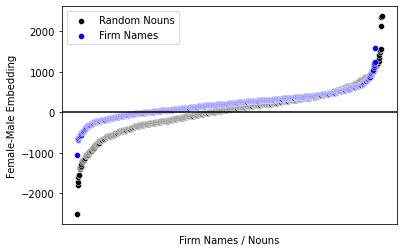

In [21]:
# Plot difference between selected dimensions for firms. 

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

g1 = sns.scatterplot(data = nouns_df.sort_values(by=["Selected_Mean_Delta"], ascending=True),x = nouns_df.index, y = "Selected_Mean_Delta", color = "black", ax = ax, label = "Random Nouns")
g1 = sns.scatterplot(data = company_names.sort_values(by=["Selected_Mean_Delta"], ascending=True), x = company_names.index,y = "Selected_Mean_Delta", color = "blue", ax = ax, label = "Firm Names")

g1.set(xticklabels=[]) 
g1.set(xlabel="Firm Names / Nouns", ylabel = "Female-Male Embedding") 
g1.axhline(0, color = "black")
g1.tick_params(bottom=False)  

In [22]:
len(company_names[company_names["Selected_Mean_Delta"] > 0])/len(company_names)

0.7672634271099744

In [23]:
company_names[company_names["Selected_Mean_Delta"] == company_names["Selected_Mean_Delta"].max()]

permco companyname   Name  Count Name_Lower  Selected_Mean_Delta
551   53896   XYLEM INC  xylem      1      xylem           1584.96573

In [24]:
# Analyze companies with highest difference meaning highest bias toward female embedding. 

company_names.sort_values(by=["Selected_Mean_Delta"], ascending=False).head(10).reset_index(drop = True)

permco            companyname               Name  Count         Name_Lower  \
0   53896              XYLEM INC              xylem      1              xylem   
1    4298           STRYKER CORP            stryker      1            stryker   
2   45068            HOSPIRA INC            hospira      1            hospira   
3   12011             INTUIT INC             intuit      1             intuit   
4    2991              MOLEX INC              molex      1              molex   
5   56619           COVETRUS INC           covetrus      1           covetrus   
6   21308             NUCOR CORP              nucor      1              nucor   
7     282     ANALOG DEVICES INC     analog devices      2     analog devices   
8     194  APPLIED MATERIALS INC  applied materials      2  applied materials   
9   20609       DUKE REALTY CORP        duke realty      2        duke realty   

   Selected_Mean_Delta  
0          1584.965730  
1          1235.080978  
2          1214.610404  
3          1158.537293  
4          1129.929935  
5          1055.386118  
6          1030.015237  
7          1009.555233  
8           993.592642  
9           989.111395

In [ ]:
# Check for difference between sectors. 
# Only possible for limited company list. 

"""

sp_500_groupedby_industry = company_names.groupby("Sector").mean().sort_values(by=["Selected_Mean_Delta"], 
                                                                        ascending=False)
sns.barplot(data = sp_500_groupedby_industry, y = sp_500_groupedby_industry.index, 
            x= "Selected_Mean_Delta", color = "black")

## 3. Other

In [51]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

In [20]:
all_embeddings = pd.DataFrame()

for company in tqdm(company_names[company_names["Count"] == 1]["Name"]):
    comparison = pd.read_csv(f"{path}{company}.csv", index_col = 0)
    comparison.sort_index(inplace = True)
    comparison = comparison.transpose()
    comparison = comparison.iloc[[3]]
    comparison.rename(index = {"female-male":f"{company}"}, inplace = True)
    comparison["Type"] = "Single-Word"
    all_embeddings = all_embeddings.append(comparison)
    
    
for company in tqdm(company_names[company_names["Count"] > 1]["Name"]):
    comparison = pd.read_csv(f"{path}{company}.csv", index_col = 0)
    comparison.sort_index(inplace = True)
    comparison = comparison.transpose()
    comparison = comparison.iloc[[3]]
    comparison.rename(index = {"female-male":f"{company}"}, inplace = True)
    comparison["Type"] = "Multi-Word"
    all_embeddings = all_embeddings.append(comparison)
    
    
for noun in tqdm(nouns_sample):
    comparison = pd.read_csv(f"{path}{noun}.csv", index_col = 0)
    comparison.sort_index(inplace = True)
    comparison = comparison.transpose()
    comparison.drop("tuple", inplace = True)
    comparison = comparison.iloc[[0]]
    comparison.rename(index = {"female-male":f"{noun}"}, inplace = True)
    comparison["Type"] = "Noun"
    all_embeddings = all_embeddings.append(comparison)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


all_embeddings_scaled = pd.DataFrame(scaler.fit_transform(all_embeddings.drop("Type", axis = 1)))

In [37]:
all_embeddings_scaled["Type"] = 0

In [47]:
all_embeddings.reset_index(inplace = True)

In [49]:
all_embeddings_scaled["Type"] = all_embeddings["Type"]

<AxesSubplot:xlabel='Dim1', ylabel='Dim2'>

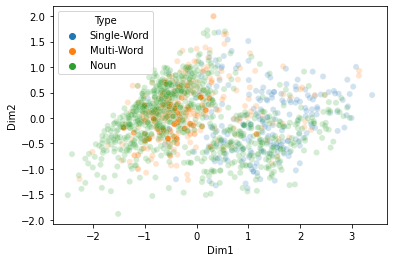

In [52]:
pca = PCA(n_components=3)
pca_res = pca.fit_transform(all_embeddings_scaled.drop("Type", axis = 1))
pca_df = pd.DataFrame({'Dim1': pca_res[:,0], 'Dim2': pca_res[:,1], 'Dim3': pca_res[:,2], "Type" : all_embeddings["Type"]})
sns.scatterplot(data = pca_df, x = "Dim1", y = "Dim2", hue = "Type", alpha = 0.2)

<AxesSubplot:xlabel='Dim1', ylabel='Dim2'>

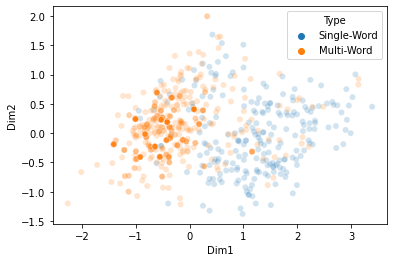

In [53]:
sns.scatterplot(data = pca_df[pca_df["Type"] != "Noun"], x = "Dim1", y = "Dim2", hue = "Type", alpha = 0.2)

<AxesSubplot:xlabel='x', ylabel='y'>

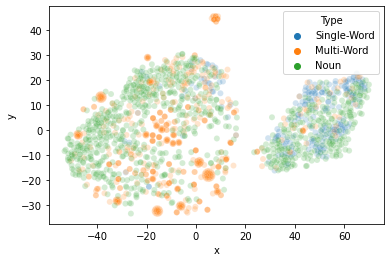

In [32]:
X_tsne_doc = TSNE(n_components=2, random_state=32, perplexity = 40, n_iter = 3000).fit_transform(all_embeddings.drop("Type", axis = 1))
select_df = pd.DataFrame({"Type":all_embeddings["Type"], "x":X_tsne_doc[:,0], "y":X_tsne_doc[:,1]})
sns.scatterplot(data = select_df, x = "x", y = "y", hue = "Type", alpha = 0.2)

<AxesSubplot:xlabel='x', ylabel='y'>

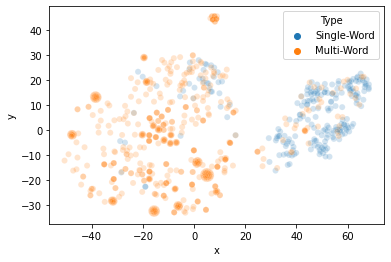

In [33]:
sns.scatterplot(data = select_df[select_df["Type"] != "Noun"], x = "x", y = "y", hue = "Type", alpha = 0.2)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(all_embeddings.drop("Type", axis = 1), all_embeddings["Type"], test_size=0.30, random_state=101)

lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

# evaluate results
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  Multi-Word       0.77      0.80      0.78       159
        Noun       0.83      0.85      0.84       234
 Single-Word       0.73      0.62      0.67        82

    accuracy                           0.80       475
   macro avg       0.78      0.76      0.77       475
weighted avg       0.79      0.80      0.79       475

